In [1]:
import sys
sys.path.append('/opt/conda/pkgs')
sys.path.append("/home/miaocj/docker_dir/kNN-overlap-finder/.snakemake/conda/4262b1bf4bf1ffb403c0eb7a42ad5906_/lib/python3.12/site-packages")
sys.path.append("/home/miaocj/docker_dir/kNN-overlap-finder/.snakemake/conda/4506eccf78279d93d0e8a34c035e91c5_/lib/python3.12/site-packages")
sys.path.append("/home/miaocj/docker_dir/kNN-overlap-finder/.snakemake/conda/6bda807e3967eae797c7b1b9eeaee8db_/lib/python3.12/site-packages")
sys.path.append("/home/miaocj/docker_dir/kNN-overlap-finder/.snakemake/conda/c2a47d89d1d34e789fdf782557bb7194_/lib/python3.12/site-packages")
sys.path.append("/home/miaocj/docker_dir/kNN-overlap-finder/.snakemake/conda/c6c5514ada15b890fb27d1e36371554c_/lib/python3.12/site-packages")
sys.path.append("/home/miaocj/docker_dir/kNN-overlap-finder/.snakemake/conda/d964a294c2d0fef56a434c021026281e_/lib/python3.12/site-packages")
sys.path.append("/home/miaocj/docker_dir/kNN-overlap-finder/.snakemake/conda/e1c932db5cd4271709e54d8028824bc9_/lib/python3.12/site-packages")

import pickle, os, gzip, json, sys, itertools
from pathlib import Path
from importlib import reload
from dataclasses import dataclass, field
import collections
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import pysam
import scipy as sp
import seaborn
import sharedmem


plt.rcParams["figure.facecolor"] = "white"
plt.rcParams["figure.dpi"] = 300


sys.path.append("scripts")
sys.path.append("../../scripts")
MAX_SAMPLE_SIZE = int(1e9)
COVERAGE_DEPTH = 20
max_bucket_size = COVERAGE_DEPTH * 1.5

In [2]:
from graph import OverlapGraph, GenomicInterval, get_overlap_statistics, remove_false_edges
from plots import plot_read_graph, mp_plot_read_graphs, get_graphviz_layout, get_umap_layout

/home/miaocj/docker_dir/kNN-overlap-finder/scripts/../lib


In [30]:
import glob
evaluate_dir = '/home/miaocj/docker_dir/kNN-overlap-finder/data/evaluation/TAIR/chr3/pbsim_ONT_93_30k/kmer_k16/'
file_list = glob.glob(evaluate_dir + '*tsv')  
  
# 循环打开文件  
statistic_dfs =[]
for file in file_list:  
    df = pd.read_csv(file, sep='\t') 
    statistic_dfs.append(df)

all_stat_df = pd.concat(statistic_dfs,ignore_index = True)
all_stat_df['connected_fraction'] = 1 - all_stat_df['singleton_fraction']
##筛选用于绘图的method
methods = all_stat_df['description'].unique()
visul_method = []
for method in methods:
    if '_IDF' in method:
        visul_method.append(method)

# method_compare = all_stat_df[all_stat_df['description'].isin(visul_method)] 
# df = method_compare

# visul_method

In [31]:
visul_method

['HNSW_Euclidean_Spectural_500d_IDF',
 'WeightedMinHash_Jaccard_None_IDF',
 'Exact_Euclidean_None_IDF',
 'Exact_Cosine_None_IDF',
 'SimHash_Cosine_None_IDF',
 'HNSW_Cosine_Spectural_500d_IDF']

In [36]:
preprocess = ['TF','IDF','TF-IDF','None']
visul_method = []
for i in preprocess:
    method = 'HNSW_Cosine_Spectural_500d_' + i
    visul_method.append(method)
df= all_stat_df[all_stat_df['description'].isin(visul_method)] 

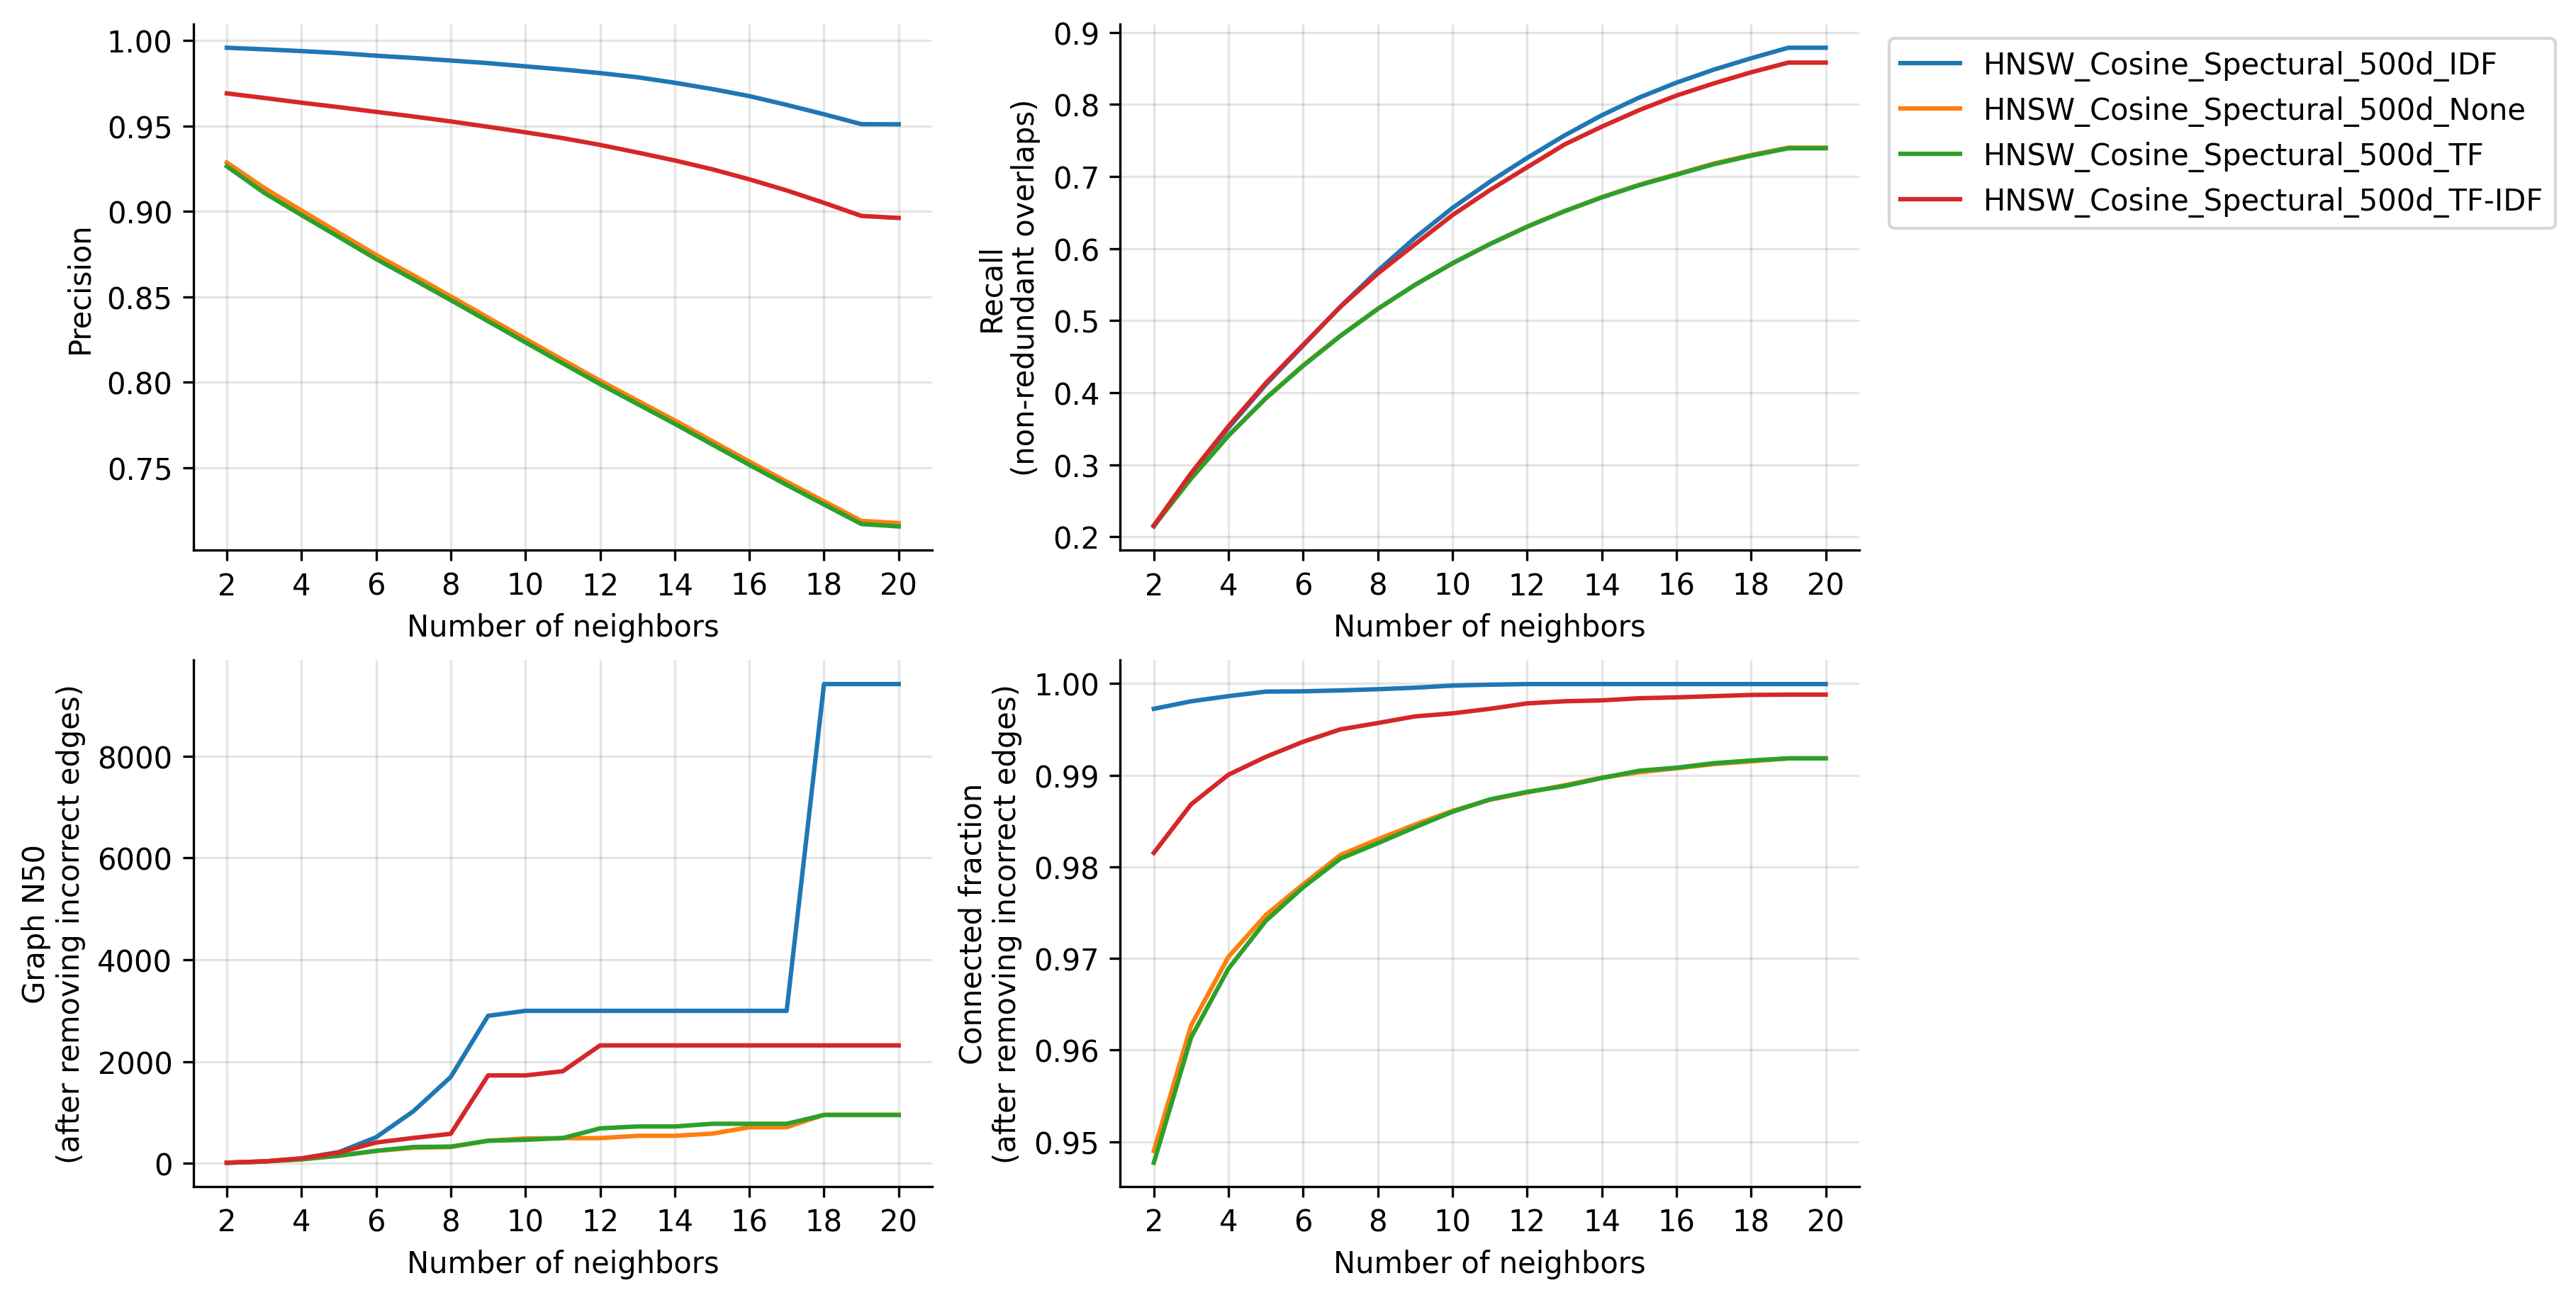

In [37]:
k_values = np.arange(2, 21)
y_labels = dict(
    precision="Precision",
    nr_recall="Recall\n(non-redundant overlaps)",
    N50="Graph N50\n(after removing incorrect edges)",
    connected_fraction="Connected fraction\n(after removing incorrect edges)"
)

if len(visul_method) <= 10:
    color_list = seaborn.color_palette("tab10")
elif len(visul_method) <= 20:
    color_list = seaborn.color_palette("tab20")
else:
    color_list = seaborn.color_palette("rainbow")

fig, axes = plt.subplots(2, 2, figsize=(12, 6), constrained_layout=True)
for i, ax in enumerate( itertools.chain(*axes) ):
    y = list(y_labels)[i]
    x = 'n_neighbors'
    hue = 'description'
    for j,(desc, group) in enumerate(df.groupby(hue)): 
        if 'Gau' in desc:  
            linestyle = 'dashed'  
        elif 'Block' in desc: 
            linestyle = 'solid'
        elif '--' in desc:
            linestyle = 'dashdot'
        else:
            linestyle = 'solid'
        ax.plot(group[x], group[y], label=desc, color =  color_list[j], linestyle = linestyle)
    ax.set_xticks([ x for x in k_values if x%2==0]) 
    ax.set_xlabel("Number of neighbors")  
    ax.set_ylabel(y_labels[y])  
    ax.grid(axis='both', color='k', alpha=0.1)  
    
    if i == 1:
        ax.legend(loc="upper left", bbox_to_anchor=(1.02, 1))

    ax.spines[['top', 'right']].set_visible(False)

In [ ]:
#visul_method = ['SimHash_TF','SimHash_TF-IDF', 'SimHash_None','MinHash_Jaccard_None_None','Minimap2']
visul_method =[
'Exact_Cosine_SimHash_3200d_None',
'Exact_Euclidean_GaussianRP_3200d_None',
 'Exact_Euclidean_SparseRP_3200d_None',
 'Exact_Cosine_GaussianRP_3200d_None',
 'Exact_Cosine_SparseRP_3200d_None',
 'HNSW_Cosine_SparseRP_500d_TF-IDF']
df= all_stat_df[all_stat_df['description'].isin(visul_method)] 
#df = df.replace({'MinHash_Jaccard_None_None':'MinHash','SimHash_None':'SimHash'})  

In [ ]:
visul_method =[ 'Exact_Cosine_GaussianRP_500d_None',
 'isomap',
 'PCA',
 'spectrual',
 'scBimap',
 'Exact_Cosine_SparseRP_500d_None']
df= all_stat_df[all_stat_df['description'].isin(visul_method)] 

In [82]:

visul_method =['Exact_Cosine_None_TF-IDF',
               'HNSW_Cosine_GaussianRP_500d_TF-IDF',
               'Minimap2',
               'MinHash_Jaccard_None_None',
               'HNSW_Cosine_SparseRP_3200d_None']
df= all_stat_df[all_stat_df['description'].isin(visul_method)] 

In [83]:
df[df.n_neighbors == 6].sort_values(by='description')

Unnamed: 0                         description  n_neighbors  repeat_time  \
612           4            Exact_Cosine_None_TF-IDF            6          NaN   
764           4  HNSW_Cosine_GaussianRP_500d_TF-IDF            6          NaN   
517           4           MinHash_Jaccard_None_None            6          NaN   
213           4                            Minimap2            6          NaN   

     precision  nr_precision    recall  nr_recall  singleton_count  \
612   0.652433      0.145718  0.093891   0.347325              950   
764   0.631342      0.137103  0.090868   0.326836             1037   
517   0.634097      0.084363  0.083232   0.183409             1038   
213   0.518826      0.058545  0.091912   0.171780             2374   

     singleton_fraction  N50 N50_percentage  continuity  connected_fraction  \
612            0.102371  226          2.44%         NaN            0.897629   
764            0.111746  235            NaN    0.050647            0.888254   
517            0.111853  385          4.15%         NaN            0.888147   
213            0.255874  536          5.78%         NaN            0.744126   

     elapsed_time:tfidf  elapsed_time:dimension_reduction  \
612            0.237896                               NaN   
764                 NaN                               NaN   
517                 NaN                               NaN   
213                 NaN                               NaN   

     elapsed_time:nearest_neighbors component_sizes  
612                        9.387611             NaN  
764                             NaN             NaN  
517                      259.072199             NaN  
213                        9.793329             NaN

In [13]:
df.loc[:,'continuity'] = df['N50']/(139853/2)

In [ ]:
simhash = pd.read_csv('/home/miaocj/docker_dir/test_simhash.csv', sep='\t')
sim_df = simhash.iloc[1368:,:]
sim_df['connected_fraction'] = 1 - sim_df['singleton_fraction']
sim = sim_df[sim_df.repeat_time ==100] 
all_df = pd.concat([all_stat_df.iloc[:,1:],sim])

In [6]:
all_stat_df = all_stat_df.replace({'MinHash_Jaccard_None_None':'MinHash'})  
visul_method = ['Minimap2','SimHash_None','MinHash']
df_HLA= all_stat_df[all_stat_df['description'].isin(visul_method)] 
df = method_compare

In [17]:
df = pd.concat([df_HLA,df_IGH,df_IGK])

In [ ]:
visul_method = ['scBimap', 'TruncatedSVD', 'spectrual', 'PCA','isomap']
method_compare = all_stat_df[all_stat_df['description'].isin(visul_method)] 
df = method_compare


In [ ]:

visul_method = ['Minimap2',
       'HNSW_Cosine_scBiMap_500d_TF-IDF','Exact_Cosine_None_TF-IDF', 'MinHash_Jaccard_None_None']
method_compare = all_stat_df[all_stat_df['description'].isin(visul_method)] 
df = method_compare

In [ ]:
methods

In [ ]:
methods
visul_method = ['Minimap2 all-vs-all',
                'WeightedMinHash,Jaccard,None,TF-IDF',
       'HNSW,Euclidean,scBiMapEmbedding,500,TF-IDF',
       'ExactNearestNeighbors,Cosine,scBiMapEmbedding,500,TF-IDF', 
       'MinHash,Jaccard,None,TF-IDF',
       'ProductQuantization,Cosine,scBiMapEmbedding,500,TF-IDF','SimHash','Blend','Exact_Cosine_None_None']
method_compare = all_df[all_df['description'].isin(visul_method)] 
df = method_compare


In [ ]:
for method in methods:
    if 'Exact' in method:
        print(method)

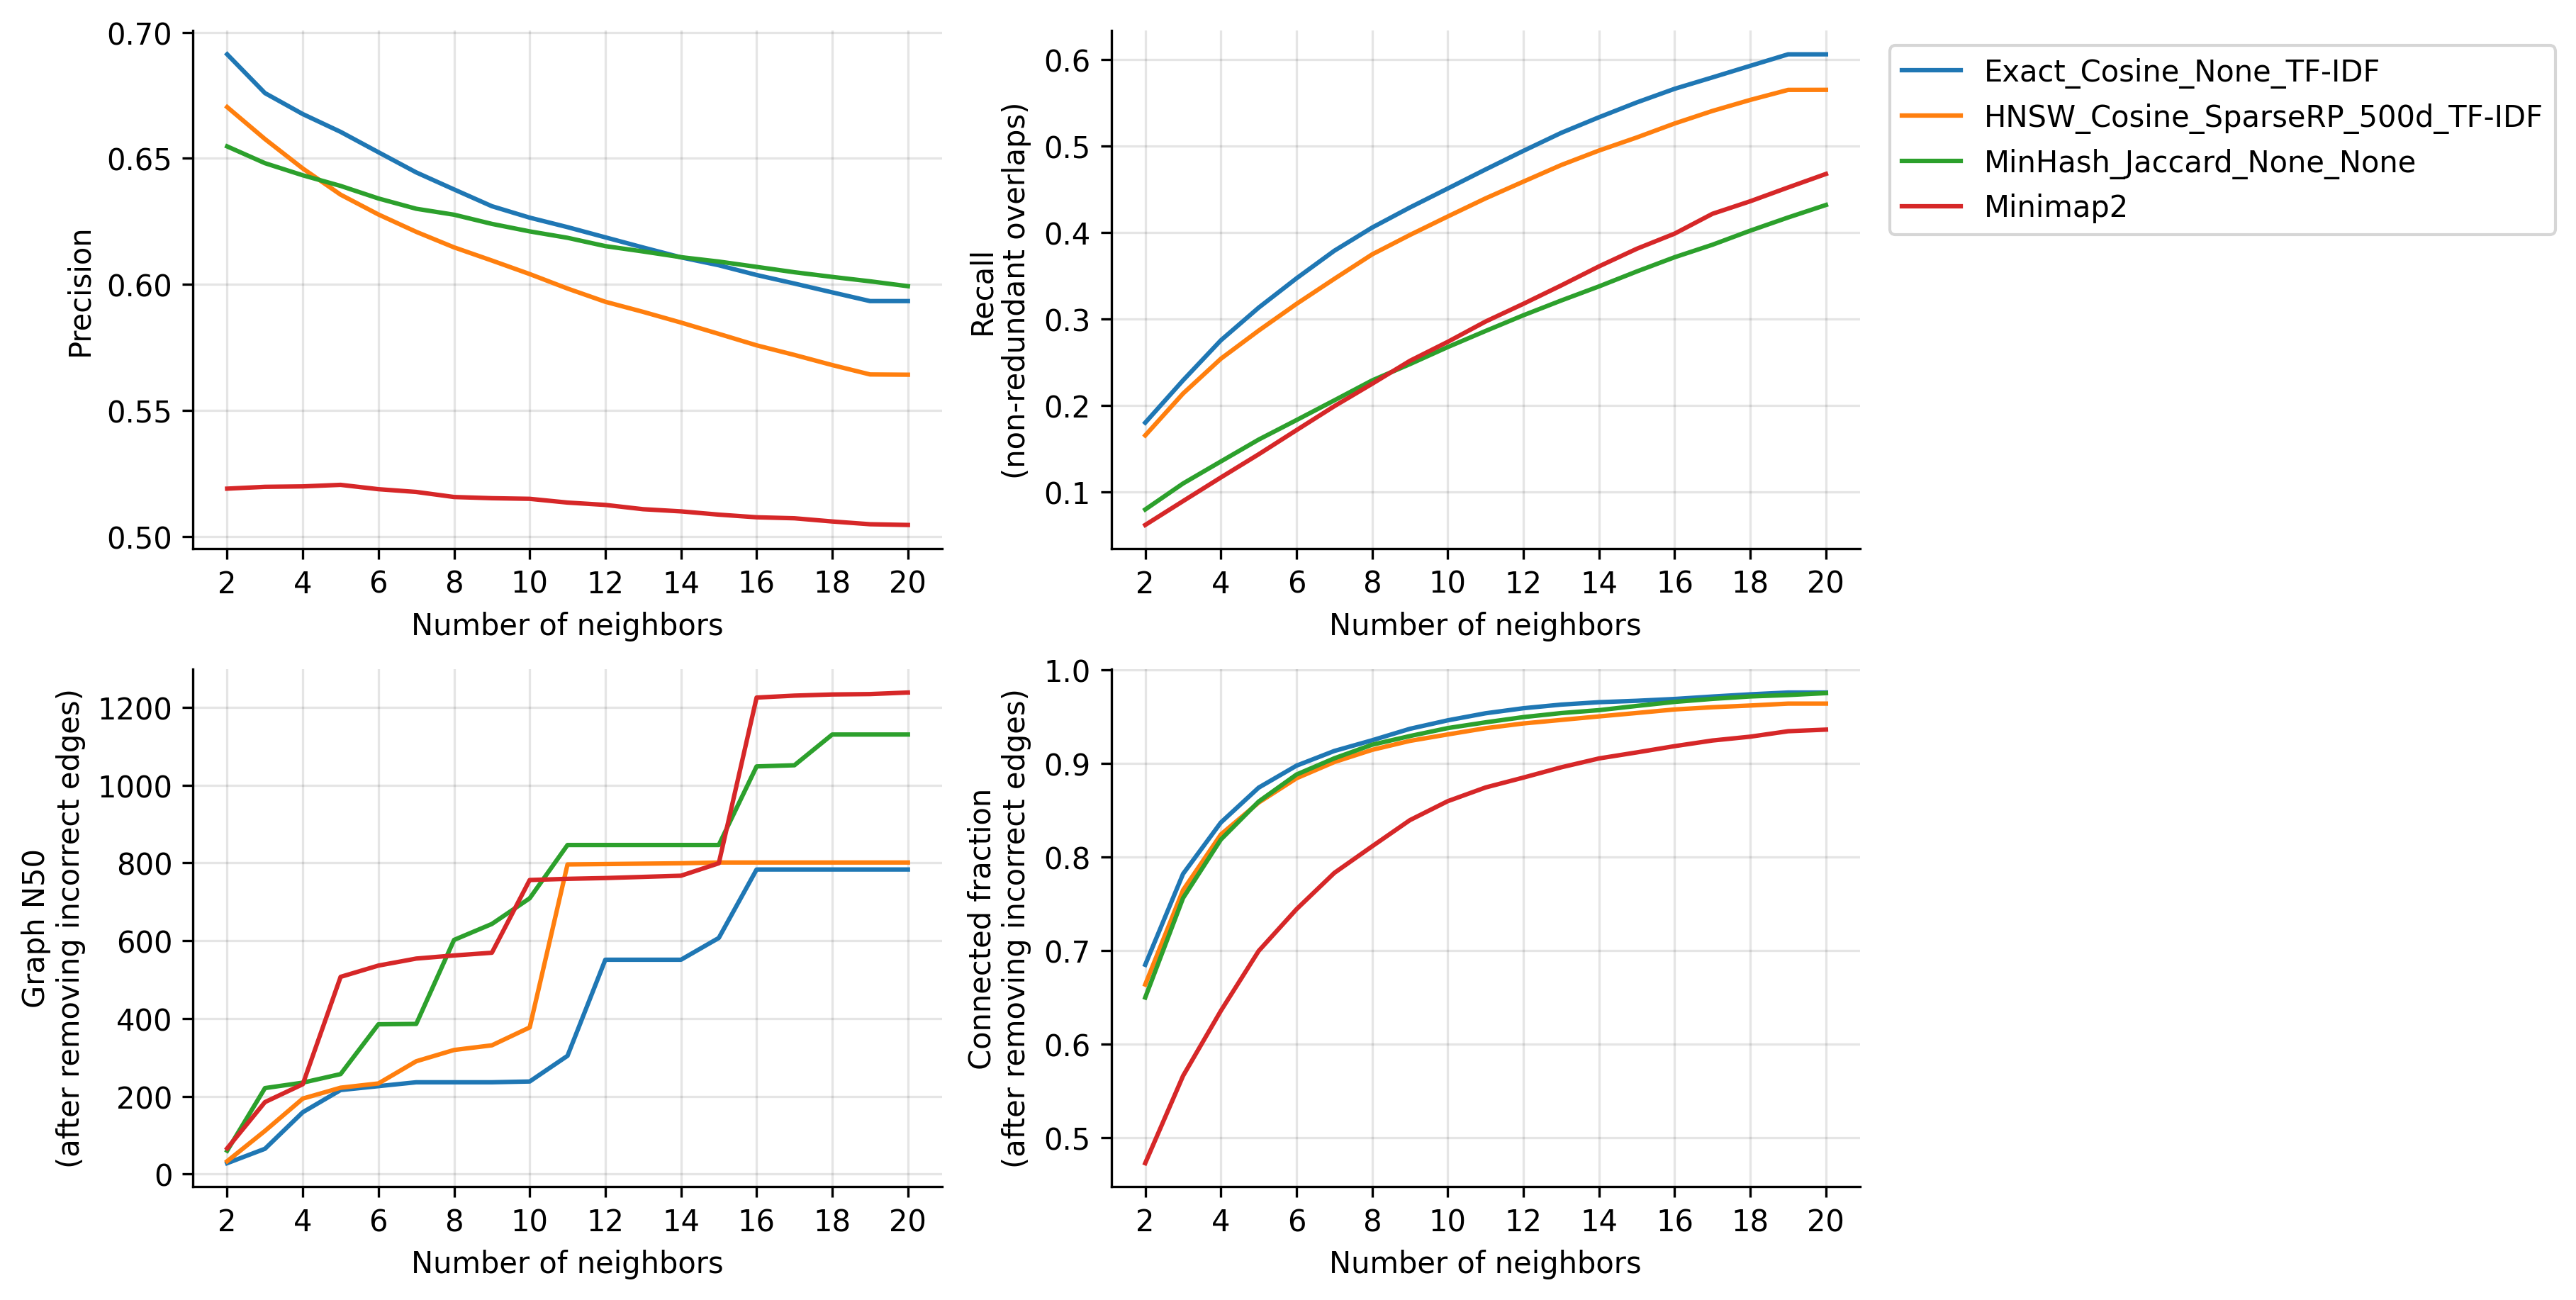

In [56]:
k_values = np.arange(2, 21)
y_labels = dict(
    precision="Precision",
    nr_recall="Recall\n(non-redundant overlaps)",
    N50="Graph N50\n(after removing incorrect edges)",
    connected_fraction="Connected fraction\n(after removing incorrect edges)"
)

if len(visul_method) <= 10:
    color_list = seaborn.color_palette("tab10")
elif len(visul_method) <= 20:
    color_list = seaborn.color_palette("tab20")
else:
    color_list = seaborn.color_palette("rainbow")

fig, axes = plt.subplots(2, 2, figsize=(12, 6), constrained_layout=True)
for i, ax in enumerate( itertools.chain(*axes) ):
    y = list(y_labels)[i]
    x = 'n_neighbors'
    hue = 'description'
    for j,(desc, group) in enumerate(df.groupby(hue)): 
        if 'Gau' in desc:  
            linestyle = 'dashed'  
        elif 'Block' in desc: 
            linestyle = 'solid'
        elif '--' in desc:
            linestyle = 'dashdot'
        else:
            linestyle = 'solid'
        ax.plot(group[x], group[y], label=desc, color =  color_list[j], linestyle = linestyle)
    ax.set_xticks([ x for x in k_values if x%2==0]) 
    ax.set_xlabel("Number of neighbors")  
    ax.set_ylabel(y_labels[y])  
    ax.grid(axis='both', color='k', alpha=0.1)  
    
    if i == 1:
        ax.legend(loc="upper left", bbox_to_anchor=(1.02, 1))

    ax.spines[['top', 'right']].set_visible(False)

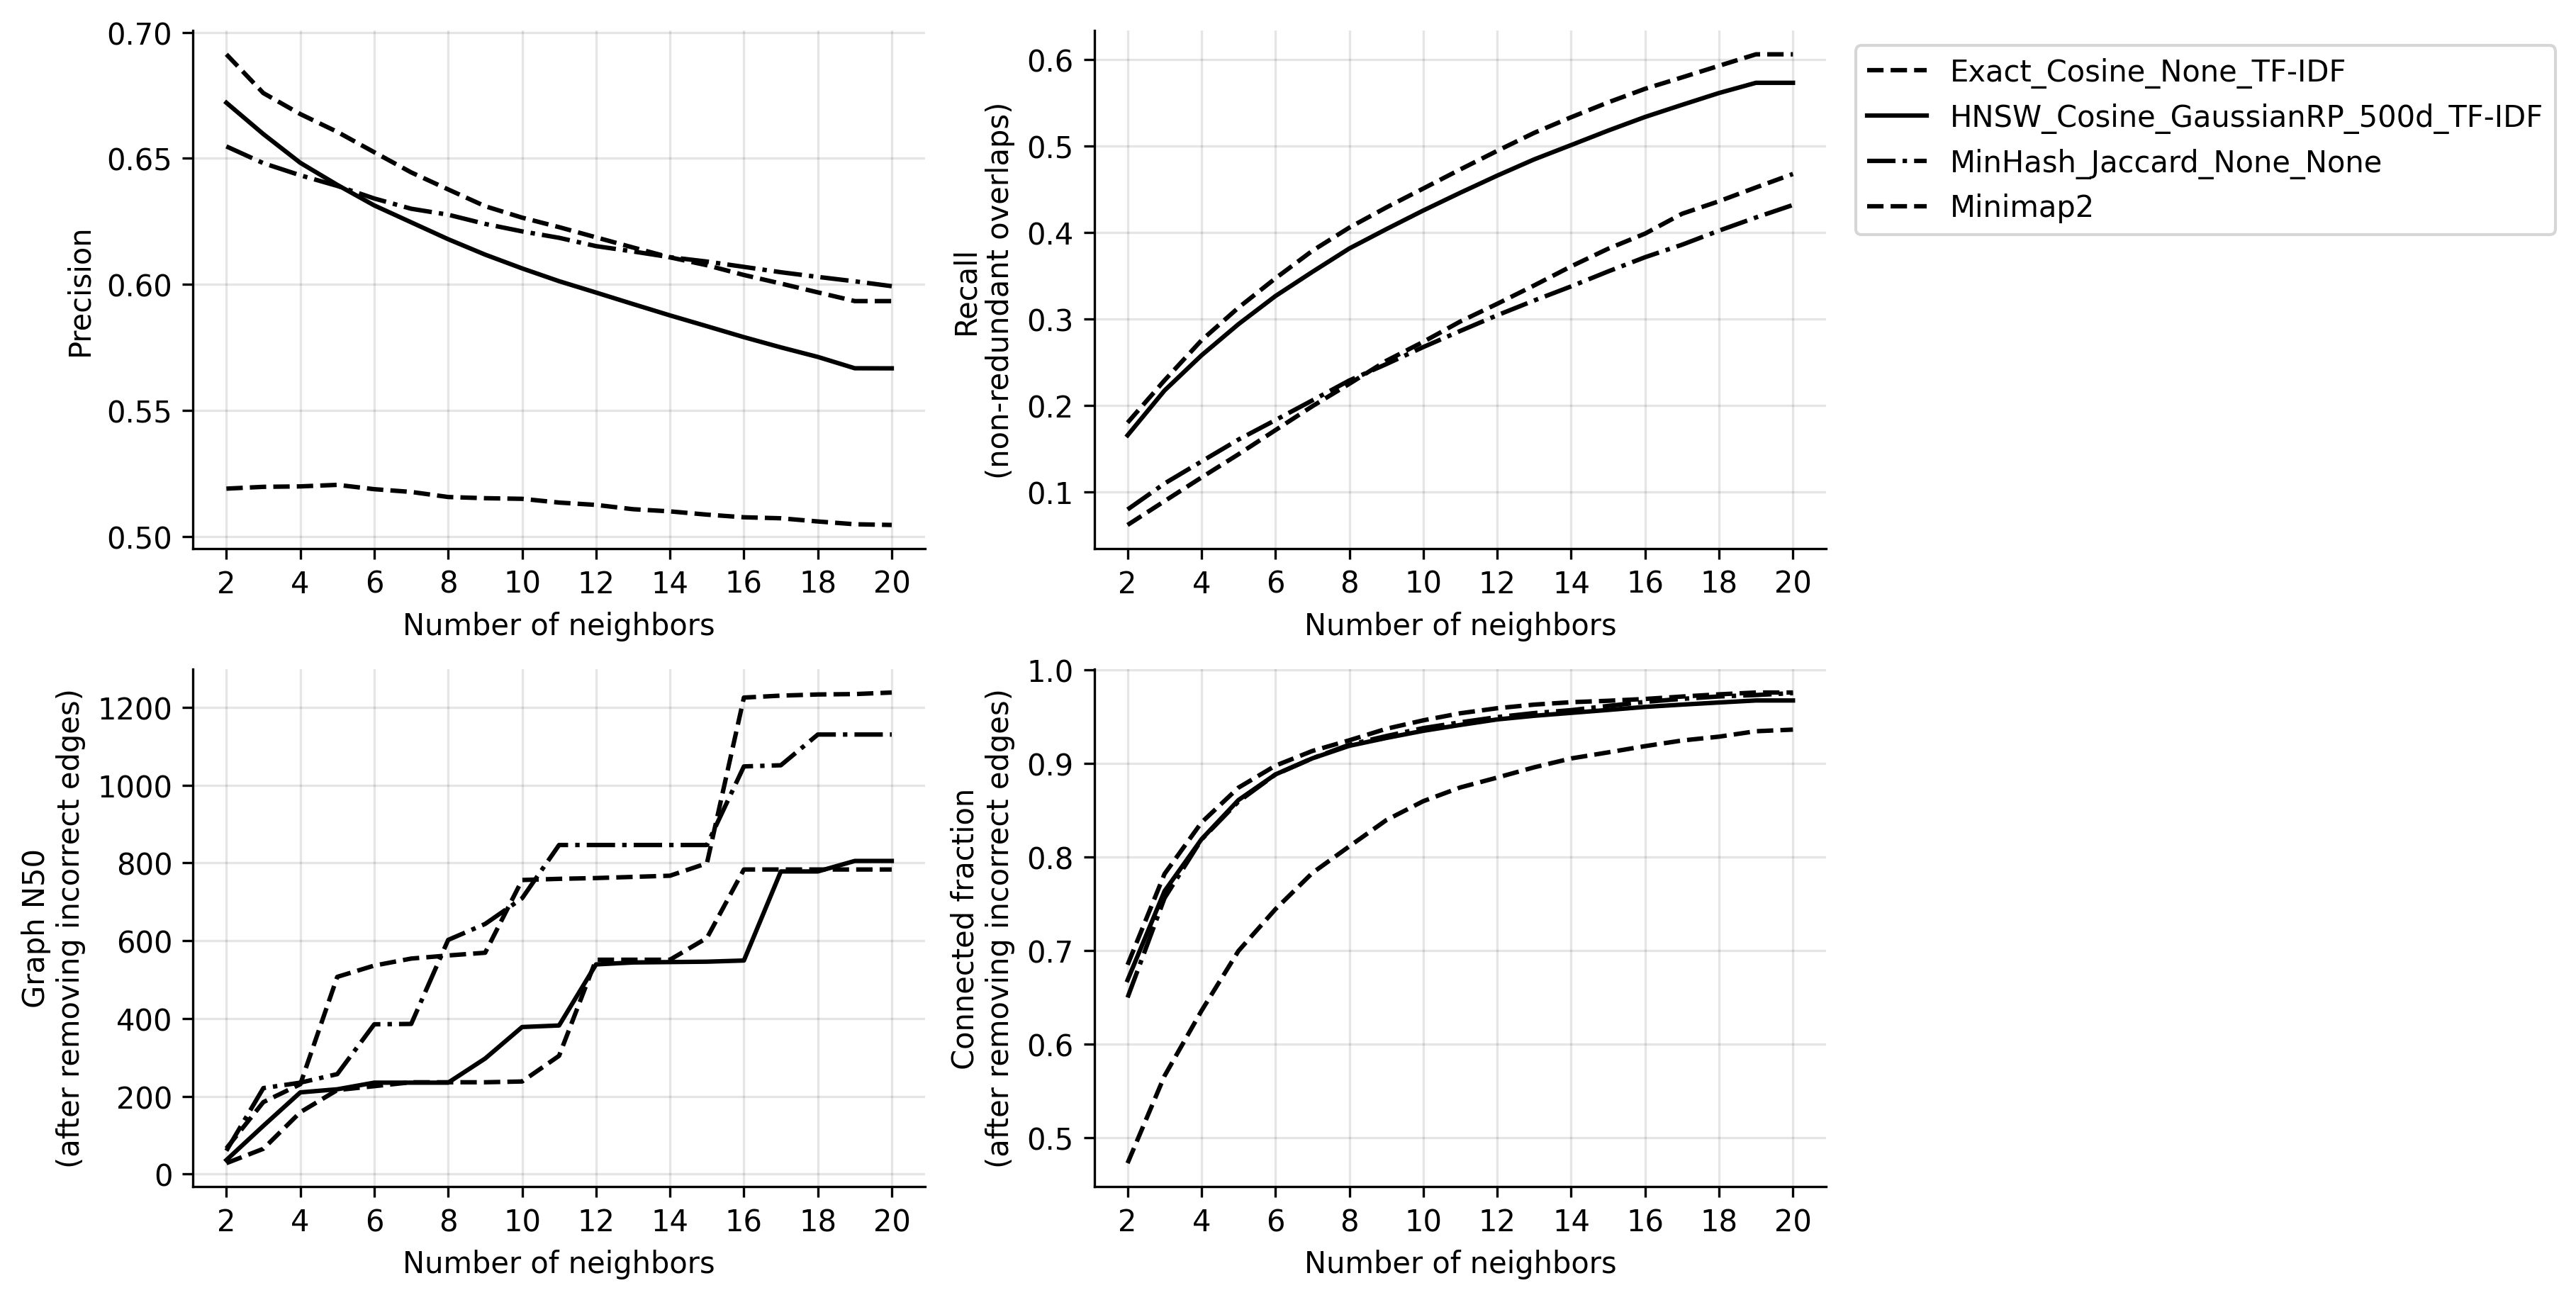

In [78]:
# all_stat_df = all_stat_df.replace({'isomap':'Isomap','scbimap':'scBiMap','pca':'PCA'})  
# df = all_stat_df
k_values = np.arange(2, 21)
y_labels = dict(
    precision="Precision",
    nr_recall="Recall\n(non-redundant overlaps)",
    N50="Graph N50\n(after removing incorrect edges)",
    connected_fraction="Connected fraction\n(after removing incorrect edges)"
)

if len(visul_method) <= 10:
    color_list = seaborn.color_palette("tab10")
elif len(visul_method) <= 20:
    color_list = seaborn.color_palette("tab20")
else:
    color_list = seaborn.color_palette("rainbow")

fig, axes = plt.subplots(2, 2, figsize=(12, 6), constrained_layout=True)
for i, ax in enumerate( itertools.chain(*axes) ):
    y = list(y_labels)[i]
    x = 'n_neighbors'
    hue = 'description'
    for j,(desc, group) in enumerate(df.groupby(hue)): 
        if 'HNSW' in desc:  
            linestyle = 'solid'  
        elif 'parse' in desc: 
            linestyle = 'dotted'
        elif 'acca' in desc:
            linestyle = 'dashdot'
        else:
            linestyle = 'dashed'
        ax.plot(group[x], group[y], label=desc, color = 'black', linestyle = linestyle)
    ax.set_xticks([ x for x in k_values if x%2==0]) 
    ax.set_xlabel("Number of neighbors")  
    ax.set_ylabel(y_labels[y])  
    ax.grid(axis='both', color='k', alpha=0.1)  
    
    if i == 1:
        ax.legend(loc="upper left", bbox_to_anchor=(1.02, 1))

    ax.spines[['top', 'right']].set_visible(False)

/tmp/ipykernel_328897/2556805869.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  all_stat_df = df.replace({'isomap':'Isomap',


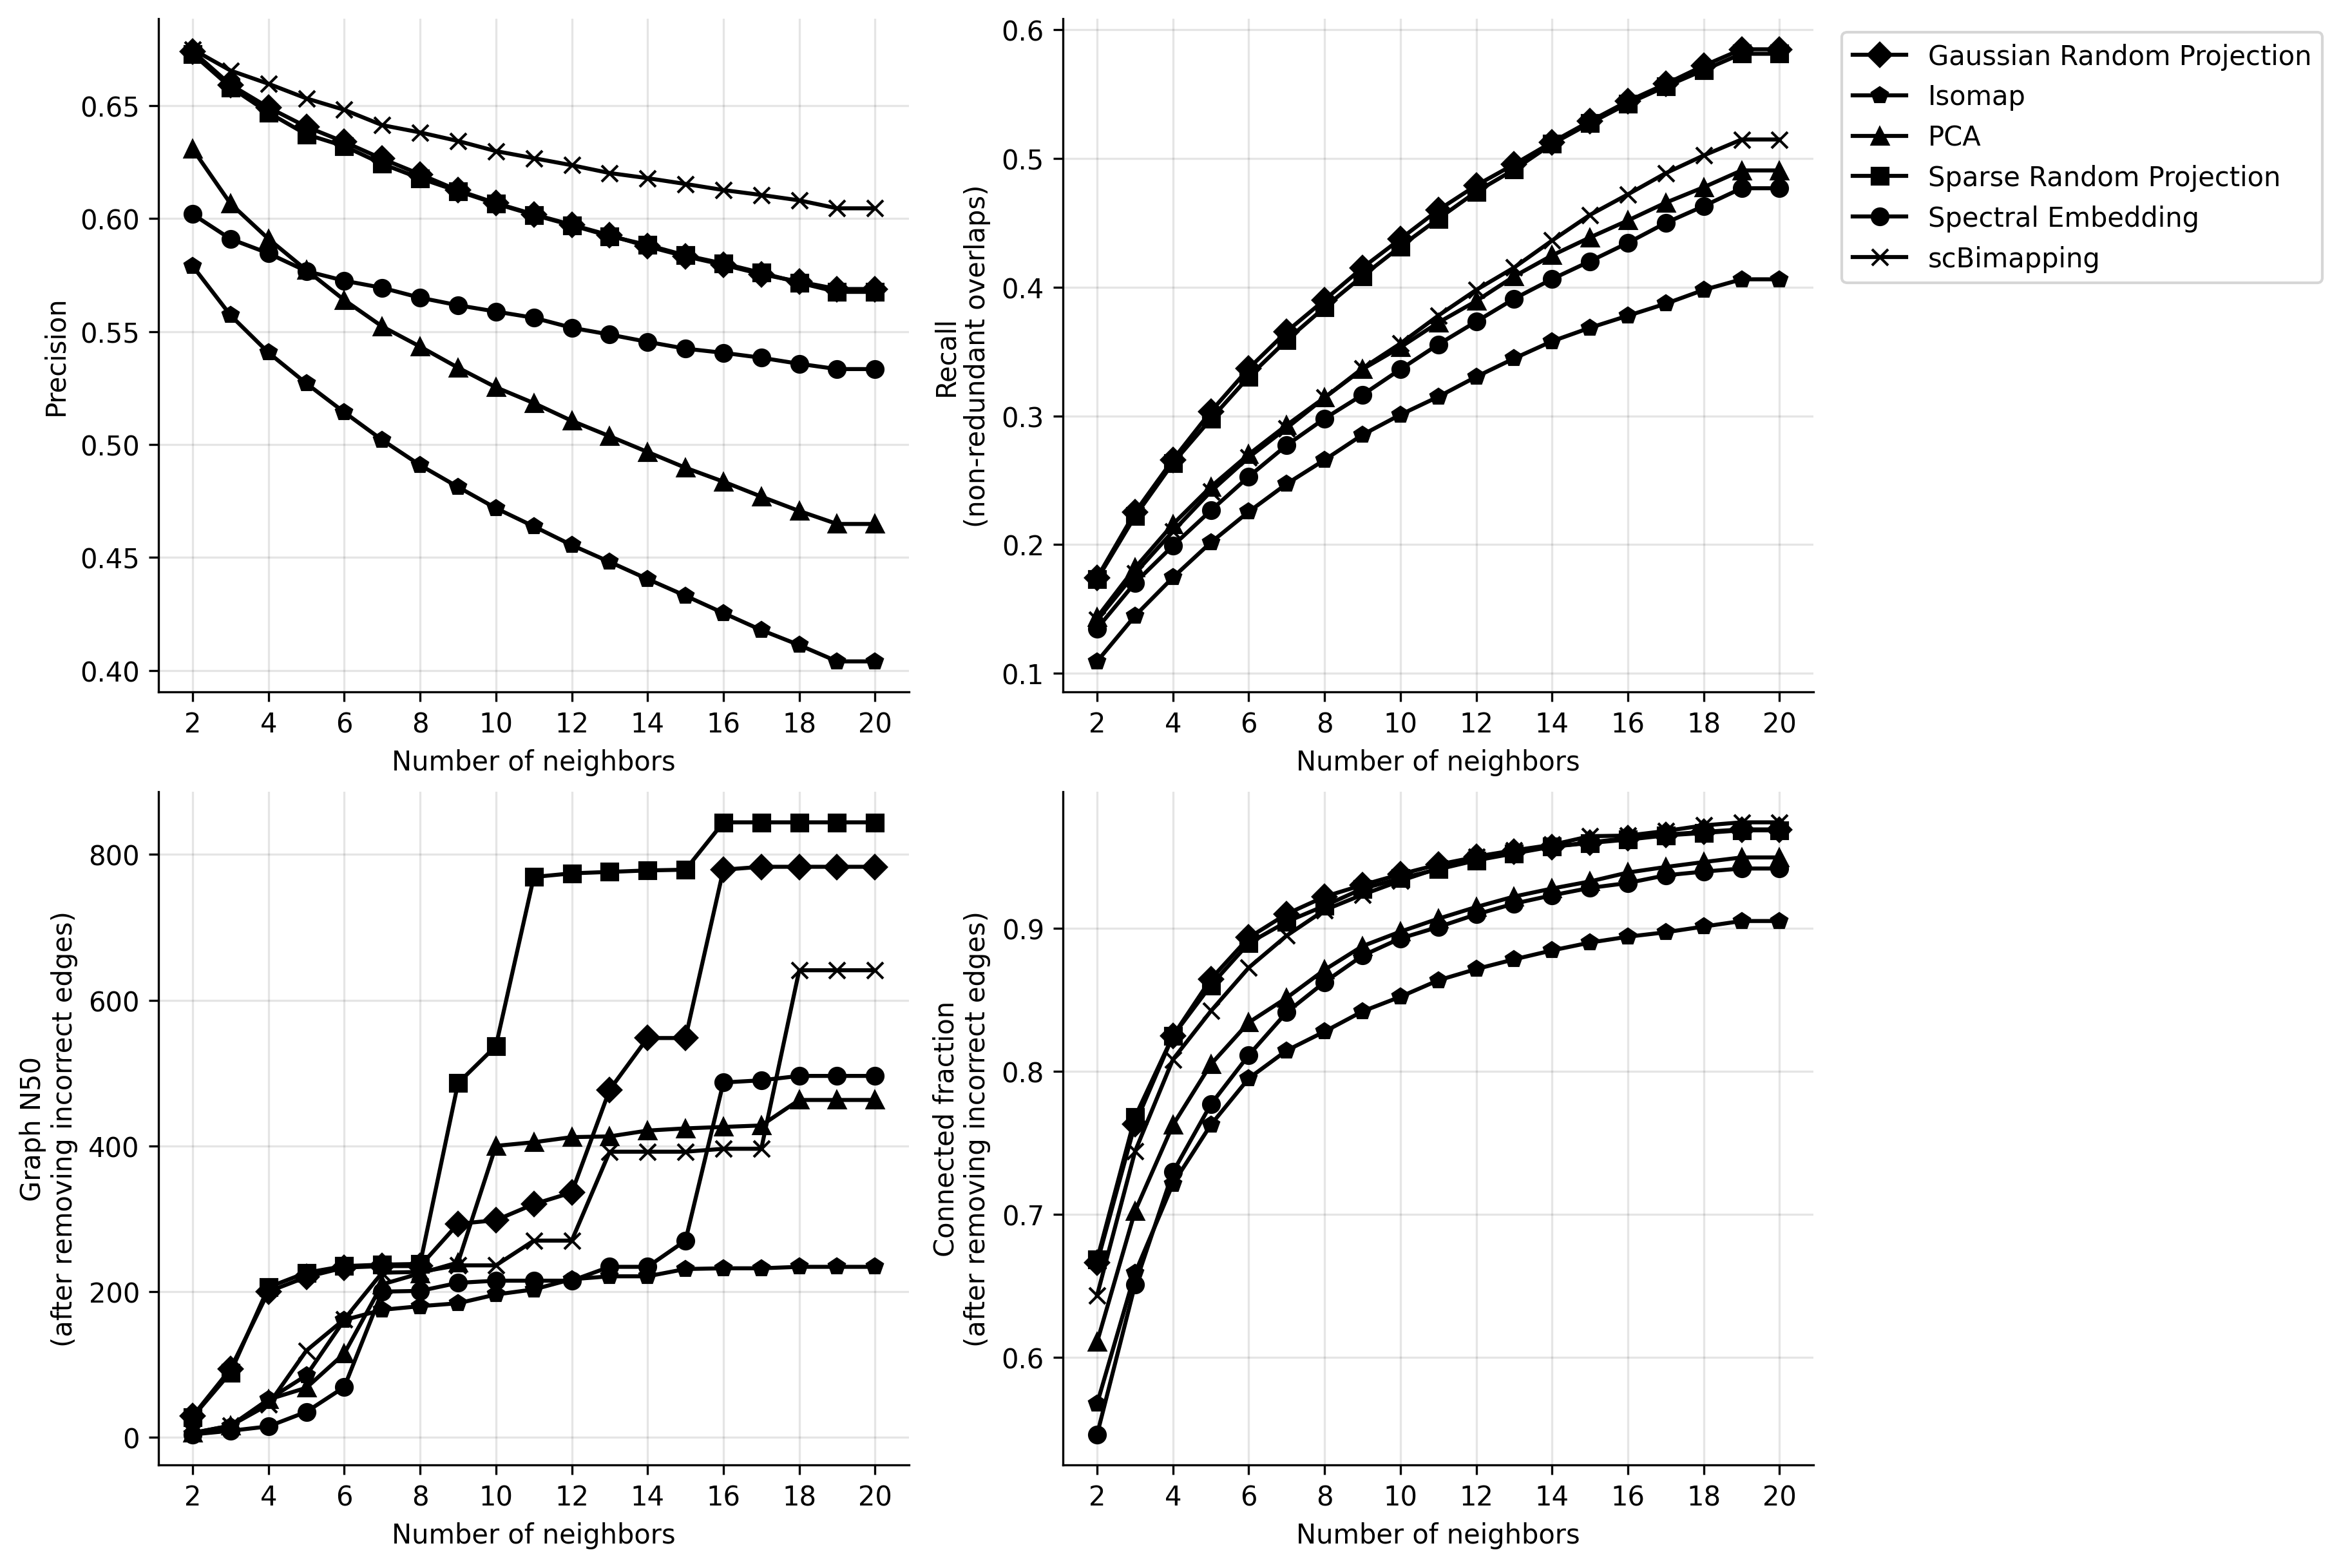

In [47]:
all_stat_df = df.replace({'isomap':'Isomap',
                          'scBimap':'scBimapping',
                          'spectrual':'Spectral Embedding',
                          'pca':'PCA',
                          'Exact_Cosine_GaussianRP_500d_None':'Gaussian Random Projection',
                          'Exact_Cosine_SparseRP_500d_None':'Sparse Random Projection'})
df = all_stat_df
k_values = np.arange(2, 21)
y_labels = dict(
    precision="Precision",
    nr_recall="Recall\n(non-redundant overlaps)",
    N50="Graph N50\n(after removing incorrect edges)",
    connected_fraction="Connected fraction\n(after removing incorrect edges)"
)

if len(visul_method) <= 10:
    color_list = seaborn.color_palette("tab10")
elif len(visul_method) <= 20:
    color_list = seaborn.color_palette("tab20")
else:
    color_list = seaborn.color_palette("rainbow")

fig, axes = plt.subplots(2, 2, figsize=(12, 8), constrained_layout=True)
for i, ax in enumerate( itertools.chain(*axes) ):
    y = list(y_labels)[i]
    x = 'n_neighbors'
    hue = 'description'
    for j,(desc, group) in enumerate(df.groupby(hue)): 
        if 'scBi' in desc:  
            marker = 'x'  
        elif 'PCA' in desc: 
            marker = '^'
        elif 'Spec' in desc:
            marker = 'o'
        elif 'Spar' in desc:
            marker = 's'
        elif 'Ga' in desc:
            marker = 'D'
        else:
            marker = 'p'
        ax.plot(group[x], group[y], label=desc, color = 'black', marker = marker)
    ax.set_xticks([ x for x in k_values if x%2==0]) 
    ax.set_xlabel("Number of neighbors")  
    ax.set_ylabel(y_labels[y])  
    ax.grid(axis='both', color='k', alpha=0.1)  
    
    if i == 1:
        ax.legend(loc="upper left", bbox_to_anchor=(1.02, 1))

    ax.spines[['top', 'right']].set_visible(False)

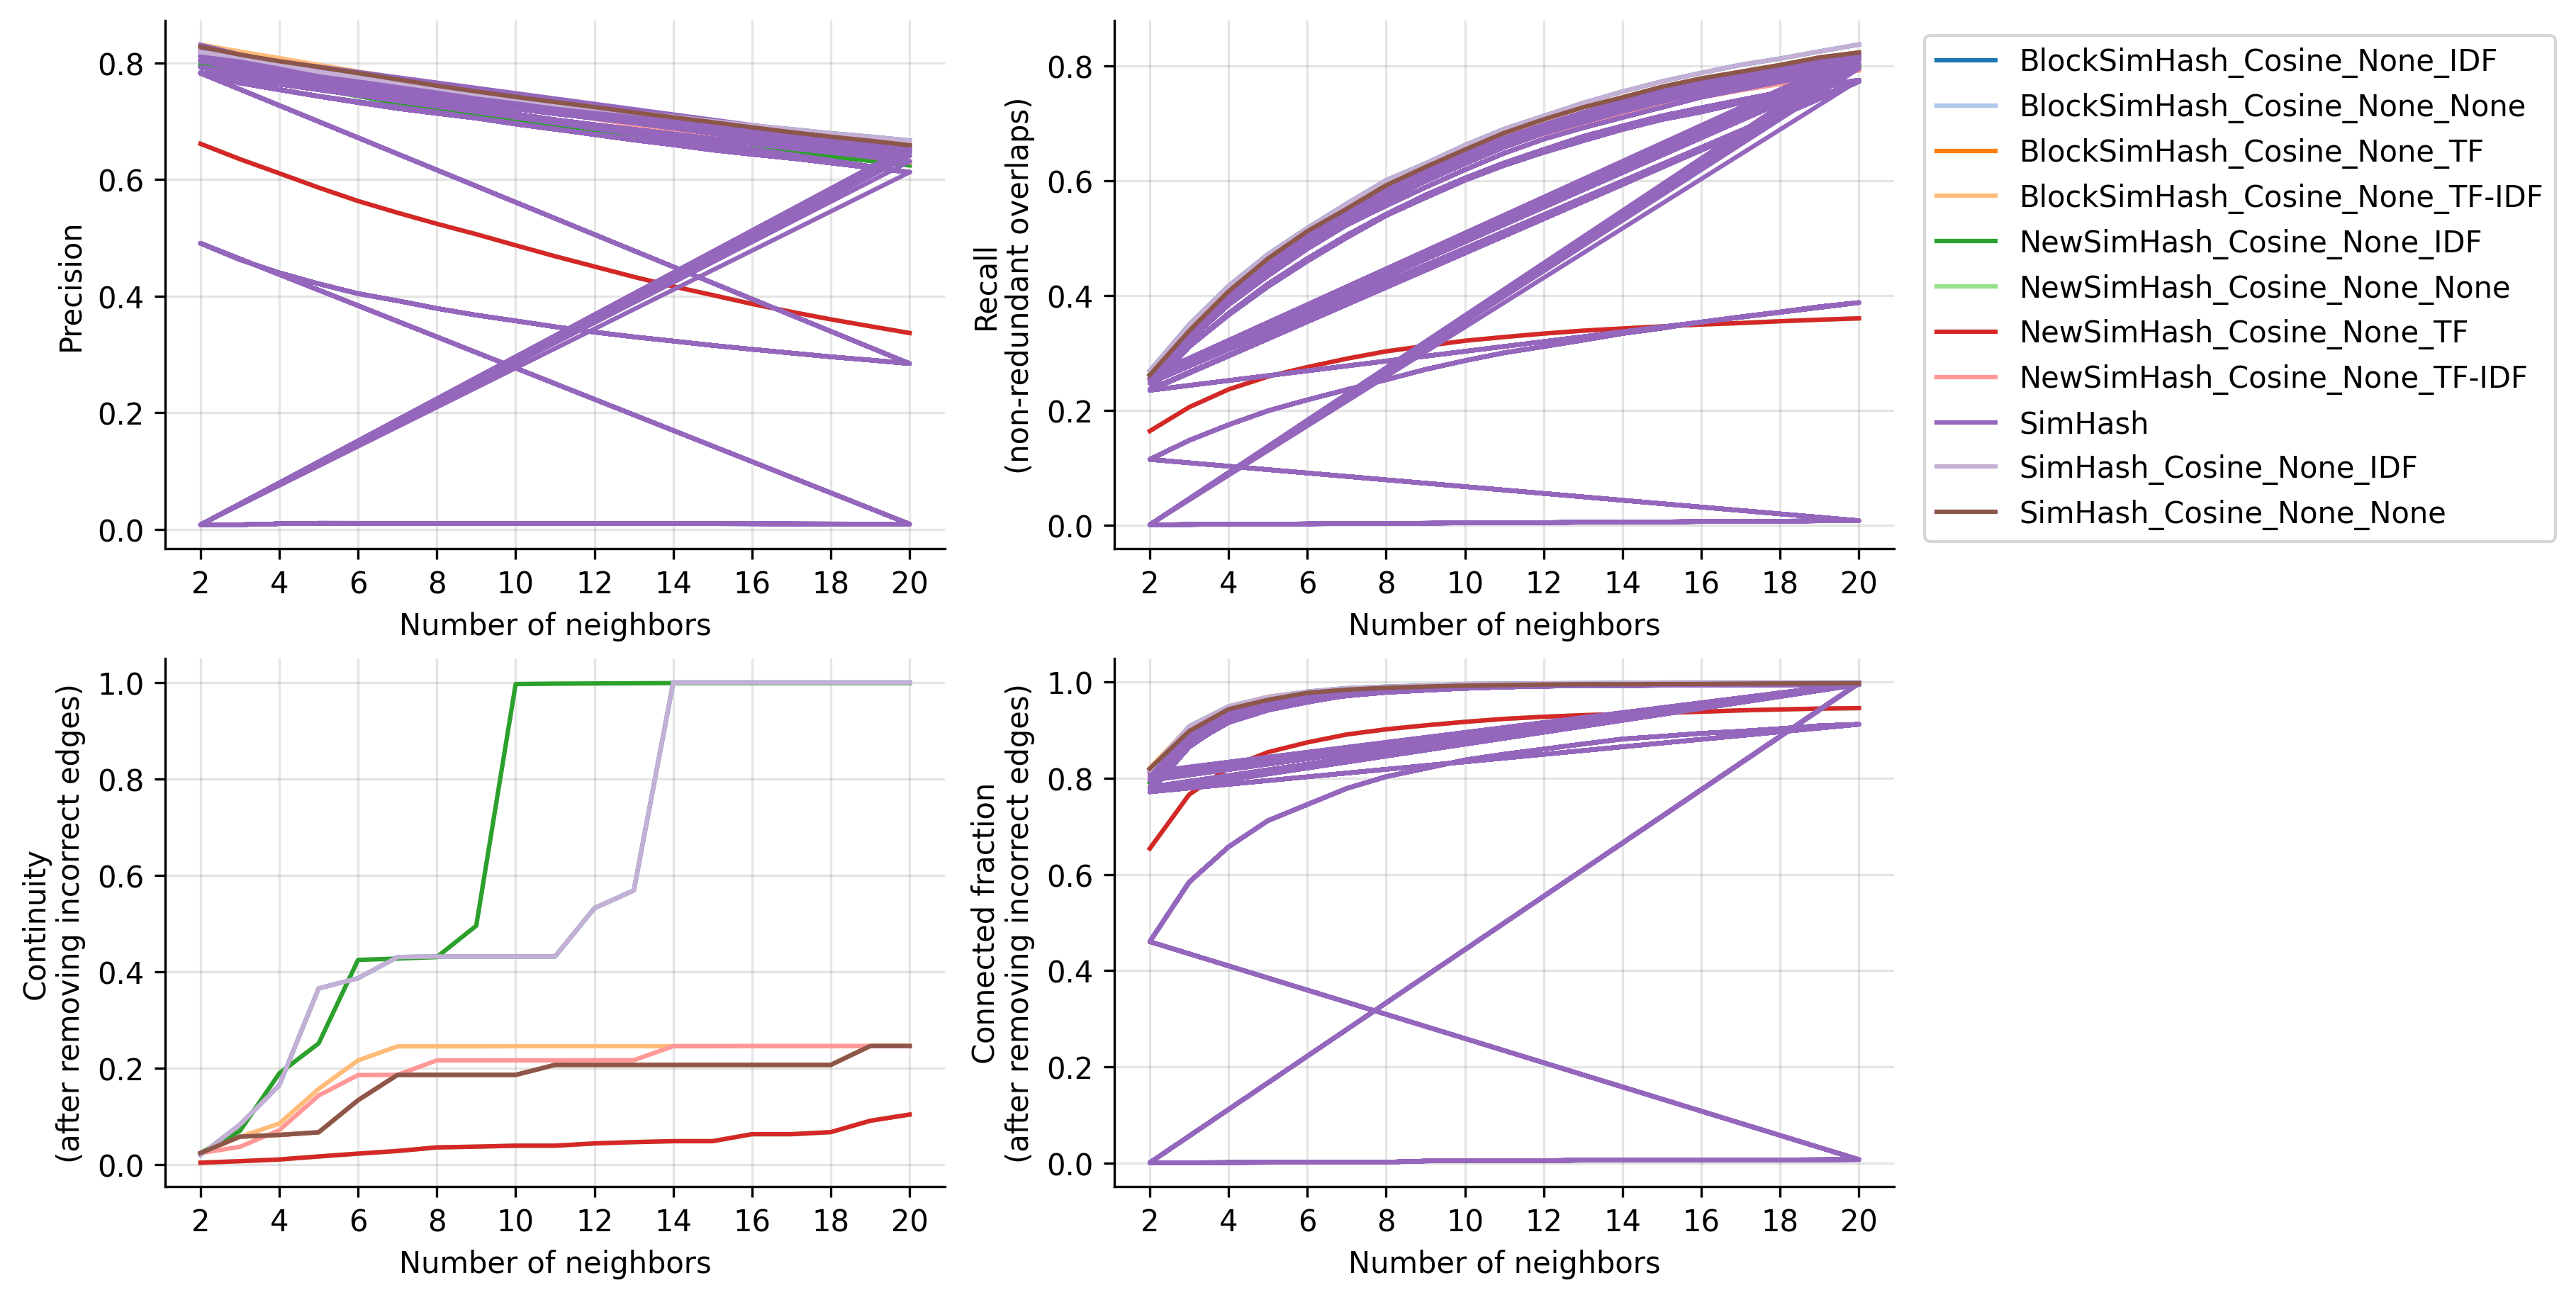

In [13]:
k_values = np.arange(2, 21)
y_labels = dict(
    precision="Precision",
    nr_recall="Recall\n(non-redundant overlaps)",
    continuity="Continuity\n(after removing incorrect edges)",
    connected_fraction="Connected fraction\n(after removing incorrect edges)"
)

if len(visul_method) <= 10:
    color_list = seaborn.color_palette("tab10")
elif len(visul_method) <= 20:
    color_list = seaborn.color_palette("tab20")
else:
    color_list = seaborn.color_palette("rainbow")

fig, axes = plt.subplots(2, 2, figsize=(12, 6), constrained_layout=True)
for i, ax in enumerate( itertools.chain(*axes) ):
    y = list(y_labels)[i]
    x = 'n_neighbors'
    hue = 'description'
    for j,(desc, group) in enumerate(df.groupby(hue)): 
        if '--' in desc:  
            linestyle = 'solid'  
        elif '64' in desc: 
            linestyle = 'dotted'
        elif '--' in desc:
            linestyle = 'dashdot'
        else:
            linestyle = 'solid'
        ax.plot(group[x], group[y], label=desc, color =  color_list[j], linestyle = linestyle)
    ax.set_xticks([ x for x in k_values if x%2==0]) 
    ax.set_xlabel("Number of neighbors")  
    ax.set_ylabel(y_labels[y])  
    ax.grid(axis='both', color='k', alpha=0.1)  
    
    if i == 1:
        ax.legend(loc="upper left", bbox_to_anchor=(1.02, 1))

    ax.spines[['top', 'right']].set_visible(False)

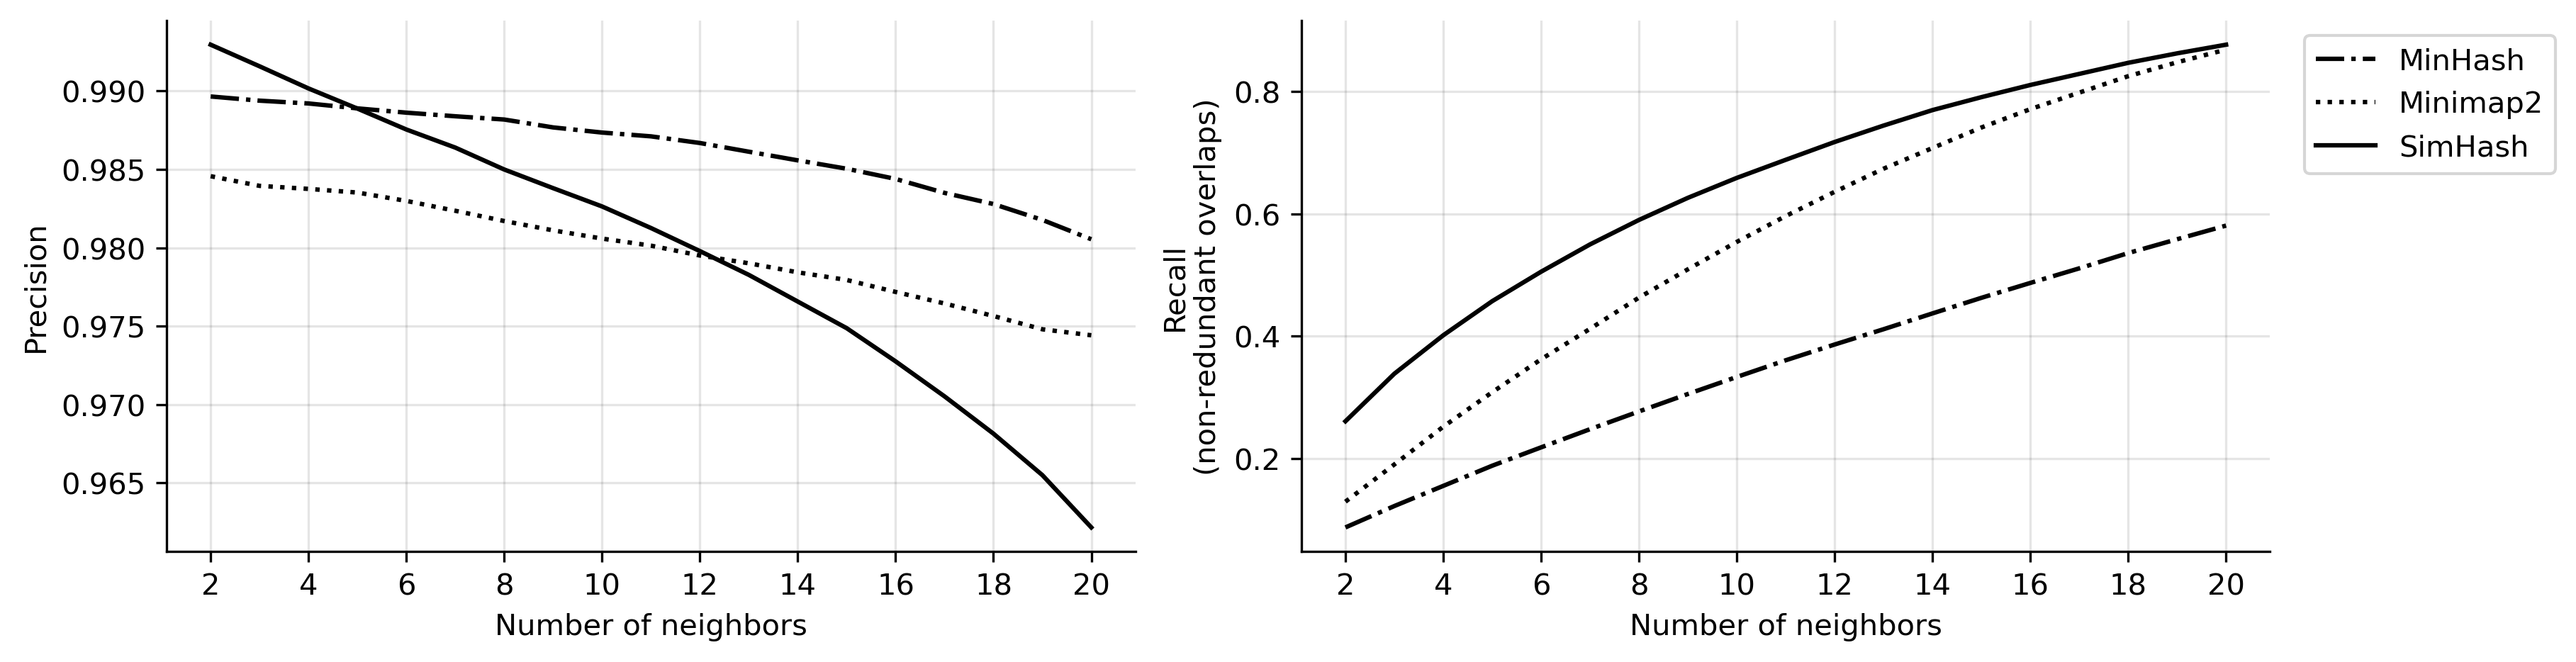

In [28]:
##仅两组
df =df_IGH
df = df.replace({'SimHash_None':'SimHash'})  

k_values = np.arange(2, 21)
y_labels = dict(
    precision="Precision",
    nr_recall="Recall\n(non-redundant overlaps)",
)

if len(visul_method) <= 10:
    color_list = seaborn.color_palette("tab10")
elif len(visul_method) <= 20:
    color_list = seaborn.color_palette("tab20")
else:
    color_list = seaborn.color_palette("rainbow")

fig, axes = plt.subplots(1,2, figsize=(12,3), constrained_layout=True)
for i, ax in enumerate(axes):
    y = list(y_labels)[i]
    x = 'n_neighbors'
    hue = 'description'
    for j,(desc, group) in enumerate(df.groupby(hue)): 
        if 'Sim' in desc:  
            linestyle = 'solid'  
        elif 'Minimap2' in desc: 
            linestyle = 'dotted'
        elif 'MinHash' in desc:
            linestyle = 'dashdot'
        else:
            linestyle = 'dashed'
        ax.plot(group[x], group[y], label=desc, color = 'black', linestyle = linestyle)
    ax.set_xticks([ x for x in k_values if x%2==0]) 
    ax.set_xlabel("Number of neighbors")  
    ax.set_ylabel(y_labels[y])  
    ax.grid(axis='both', color='k', alpha=0.1)  
    
    if i == 1:
        ax.legend(loc="upper left", bbox_to_anchor=(1.02, 1))

    ax.spines[['top', 'right']].set_visible(False)

plt.savefig('IGH_plot.pdf', format='pdf')  


In [ ]:
##放大precision 局部
k_values = np.arange(2, 21)
y_labels = dict(
    precision="Precision",
    nr_recall="Recall (non-redundant overlaps)",
    N50="Graph N50 (after removing incorrect edges)",
    connected_fraction="Connected fraction (after removing incorrect edges)"
)

color_list = seaborn.color_palette("bwr",9)


fig, ax = plt.subplots(figsize=(8, 8), constrained_layout=True) 
y = list(y_labels)[0]
x = 'n_neighbors'
hue = 'repeat_time'
for j,(desc, group) in enumerate(df.groupby(hue)): 
    ax.plot(group[x], group[y], label=desc, color = color_list[j])

ax.set_xticks(k_values)
ax.set_xlabel("Number of neighbors")  
ax.set_ylabel(y_labels[y])  
ax.set_xlim(4,10)
ax.set_ylim(0.685,0.8)
ax.grid(axis='both', color='k', alpha=0.1)  
ax.legend(loc="upper left", bbox_to_anchor=(1.02, 1))

In [ ]:
k_values
new_k =[ x for x in k_values if x%2==0]

In [ ]:
k_values = np.arange(2, 21)
y_labels = dict(
    precision="Precision",
    nr_recall="Recall (non-redundant overlaps)",
    N50="Graph N50 (after removing incorrect edges)",
    connected_fraction="Connected fraction (after removing incorrect edges)"
)

color_list = seaborn.color_palette("bwr",9)


fig, axes = plt.subplots(2, 2, figsize=(16, 10), constrained_layout=True)
for i, ax in enumerate( itertools.chain(*axes) ):
    y = list(y_labels)[i]
    x = 'n_neighbors'
    hue = 'repeat_time'
    for j,(desc, group) in enumerate(df.groupby(hue)): 

        ax.plot(group[x], group[y], label=desc, color = color_list[j])
    ax.set_xticks(k_values) 
    ax.set_xlabel("Number of neighbors")  
    ax.set_ylabel(y_labels[y])  
    ax.grid(axis='both', color='k', alpha=0.1)  
    
    if i == 1:
        ax.legend(loc="upper left", bbox_to_anchor=(1.02, 1))

    ax.spines[['top', 'right']].set_visible(False)

In [ ]:
import glob
evaluate_dir = '/home/miaocj/docker_dir/kNN-overlap-finder/data/evaluation/Ecoli/all/ONT/kmer_k16/'
file_list = glob.glob(evaluate_dir + '*_overlap_stat.tsv')  
  
# 循环打开文件  
statistic_dfs =[]
for file in file_list:  
    df = pd.read_csv(file, sep='\t') 
    statistic_dfs.append(df)

all_stat_df = pd.concat(statistic_dfs,ignore_index = True)
all_stat_df = all_stat_df.iloc[:,2:]
all_stat_df['connected_fraction'] = 1 - all_stat_df['singleton_fraction']
##筛选用于绘图的method
methods = all_stat_df['description'].unique()
visul_method = []
for method in methods:
    if  'TF-IDF' in method or 'Blend' in method or 'Mini' in method:
        visul_method.append(method)

method_compare = all_stat_df[all_stat_df['description'].isin(visul_method)] 
df2 = method_compare

visul_method

In [ ]:
time_df = df2[df2['n_neighbors']==20]
time_df.to_csv('/home/miaocj/docker_dir/kNN-overlap-finder/time_df.csv',sep='\t')

In [ ]:
time_df

In [ ]:
k_values = np.arange(2, 21)
y_labels = dict(
    precision="Precision",
    nr_recall="Recall (non-redundant overlaps)",
    N50="Graph N50 (after removing incorrect edges)",
    connected_fraction="Connected fraction (after removing incorrect edges)"
)

if len(visul_method) <= 10:
    color_list = seaborn.color_palette("tab10")
elif len(visul_method) <= 20:
    color_list = seaborn.color_palette("tab20")
else:
    color_list = seaborn.color_palette("rainbow")

fig, axes = plt.subplots(2, 2, figsize=(16, 10), constrained_layout=True)
for i, ax in enumerate( itertools.chain(*axes) ):
    y = list(y_labels)[i]
    x = 'n_neighbors'
    hue = 'description'
    for j,(desc, group) in enumerate(df2.groupby(hue)): 
        if 'HNSW' in desc:  
            linestyle = 'dashed'  
        elif 'Hash' in desc: 
            linestyle = 'dotted'
        else:
            linestyle = 'solid'
        ax.plot(group[x], group[y], label=desc, color = color_list[j],linestyle = linestyle)
    ax.set_xticks(k_values) 
    ax.set_xlabel("Number of neighbors")  
    ax.set_ylabel(y_labels[y])  
    ax.grid(axis='both', color='k', alpha=0.1)  
    
    if i == 1:
        ax.legend(loc="upper left", bbox_to_anchor=(1.02, 1))

    ax.spines[['top', 'right']].set_visible(False)

In [ ]:
k_values = np.arange(2, 21)
y_labels = dict(
    precision="Precision",
    nr_recall="Recall (non-redundant overlaps)",
    N50="Graph N50 (after removing incorrect edges)",
    connected_fraction="Connected fraction (after removing incorrect edges)"
)

if len(visul_method) <= 10:
    color_list = seaborn.color_palette("tab10")
elif len(visul_method) <= 20:
    color_list = seaborn.color_palette("tab20")
else:
    color_list = seaborn.color_palette("rainbow")

fig, axes = plt.subplots(2, 2, figsize=(16, 10), constrained_layout=True)
for i, ax in enumerate( itertools.chain(*axes) ):
    y = list(y_labels)[i]
    x = 'n_neighbors'
    hue = 'description'
    for j,(desc, group) in enumerate(df.groupby(hue)): 
        if 'Pro' in desc:  
            linestyle = 'dashed'  
        elif 'Jaccard' in desc: 
            linestyle = 'dotted'
        else:
            linestyle = 'solid'
        ax.plot(group[x], group[y], label=desc, color = color_list[j],linestyle = linestyle)
    ax.set_xticks(k_values) 
    ax.set_xlabel("Number of neighbors")  
    ax.set_ylabel(y_labels[y])  
    ax.grid(axis='both', color='k', alpha=0.1)  
    
    if i == 1:
        ax.legend(loc="upper left", bbox_to_anchor=(1.02, 1))

    ax.spines[['top', 'right']].set_visible(False)

## 绘制plot_graph

In [13]:
def remove_small_components(graph, min_component_size=10):
    small_components = set()
    for component in nx.connected_components(graph):
        if len(component) < min_component_size:
            small_components |= component
    graph.remove_nodes_from(small_components)
            
    
def plot_graphs(graphs, reference_graph, metadata, *, min_component_size=10, 
                processes=8, layout_method='stdp', figsize=(6, 6), node_size=3,title,
    seed: int = 4829, verbose=True):
    axes = []
    figures = []

    new_graphs = []
    for g in graphs:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), constrained_layout=True)
        figures.append(fig)
        ax1.set_title("All edges")
        ax2.set_title("Correct edges")
        
        g = g.copy()
        remove_small_components(g, min_component_size=min_component_size)
        new_graphs.append(g)
        axes.append(ax1)

        g = g.copy()
        remove_false_edges(g, reference_graph)
        remove_small_components(g, min_component_size=min_component_size)
        new_graphs.append(g)
        axes.append(ax2)
        fig.suptitle(title, ha="center", va="bottom", wrap=True, size=7)

    query_graphs = new_graphs
    def plot(i, pos):
        plot_read_graph(
            ax=axes[i],
            query_graph=query_graphs[i],
            reference_graph=reference_graph,
            metadata=metadata,
            pos=pos,
            node_size=node_size,
        )

    with sharedmem.MapReduce(np=processes) as pool:

        def work(i):
            if layout_method == "umap":
                pos = get_umap_layout(graph=query_graphs[i])
            else:
                pos = get_graphviz_layout(
                    graph=query_graphs[i],
                    figsize=figsize,
                    seed=seed,
                    layout_method=layout_method,
                )
            return i, pos

        def reduce(i, pos):
            if verbose:
                print(i, end=" ")
            plot(i, pos)

        pool.map(work, range(len(query_graphs)), reduce=reduce)
        if verbose:
            print("")

    return figures

In [38]:
MAX_SAMPLE_SIZE = int(1e9)
COVERAGE_DEPTH = 20
max_bucket_size = COVERAGE_DEPTH * 1.5

tsv_path = "/home/miaocj/docker_dir/kNN-overlap-finder/data/feature_matrix/CHM13/IGK/pbsim_ONT_95_10k_sampled/kmer_k16/metadata.tsv.gz"
meta_df = pd.read_table(tsv_path).iloc[:MAX_SAMPLE_SIZE, :].reset_index()

def get_read_intervals(meta_df):
    read_intervals = {
        i: [GenomicInterval(strand, start, end)]
        for i, strand, start, end in zip(
            meta_df.index,
            meta_df["reference_strand"],
            meta_df["reference_start"],
            meta_df["reference_end"],
        )
    }
    return read_intervals

read_intervals = get_read_intervals(meta_df)
len(read_intervals)

reference_graph = OverlapGraph.from_intervals(read_intervals)
nr_edges = set((node_1, node_2) for node_1, node_2, data in reference_graph.edges(data=True) if not data['redundant'])
connected_component_count = len(list(nx.connected_components(reference_graph)))
len(reference_graph.nodes), len(reference_graph.edges), len(nr_edges), connected_component_count

(5028, 46828, 8760, 2)

In [5]:
max_n_neighbors = 20
json_path = "/home/miaocj/docker_dir/kNN-overlap-finder/data/feature_matrix/CHM13/IGK/pbsim_ONT_95_10k/kmer_k16/read_features.json.gz"
with gzip.open(json_path, "rt") as f:
    read_features = json.load(f)
    read_features = {i: read_features[i] for i in meta_df.index}
    
read_ids = np.array(list(read_features))
graphs = collections.defaultdict(dict)
k_values = np.arange(2, max_n_neighbors + 1)
datas = np.load('/home/miaocj/docker_dir/kNN-overlap-finder/data/evaluation/CHM13/IGK/pbsim_ONT_95_10k/kmer_k16/Exact_Cosine_None_IDF_nbr_matrix.npz',allow_pickle=True)
nbr_indices = datas['arr_0']
for k in k_values:
    graph = OverlapGraph.from_neighbor_indices(
        neighbor_indices=nbr_indices,
        n_neighbors=k,
        read_ids=read_ids,
        require_mutual_neighbors=False,
    )
    graphs[0][k] = graph

NameError: name 'meta_df' is not defined

In [ ]:
nbr_indices.item()[0]

1 0 
CPU times: user 2.36 s, sys: 110 ms, total: 2.47 s
Wall time: 2min 5s


[<Figure size 3600x1800 with 2 Axes>]

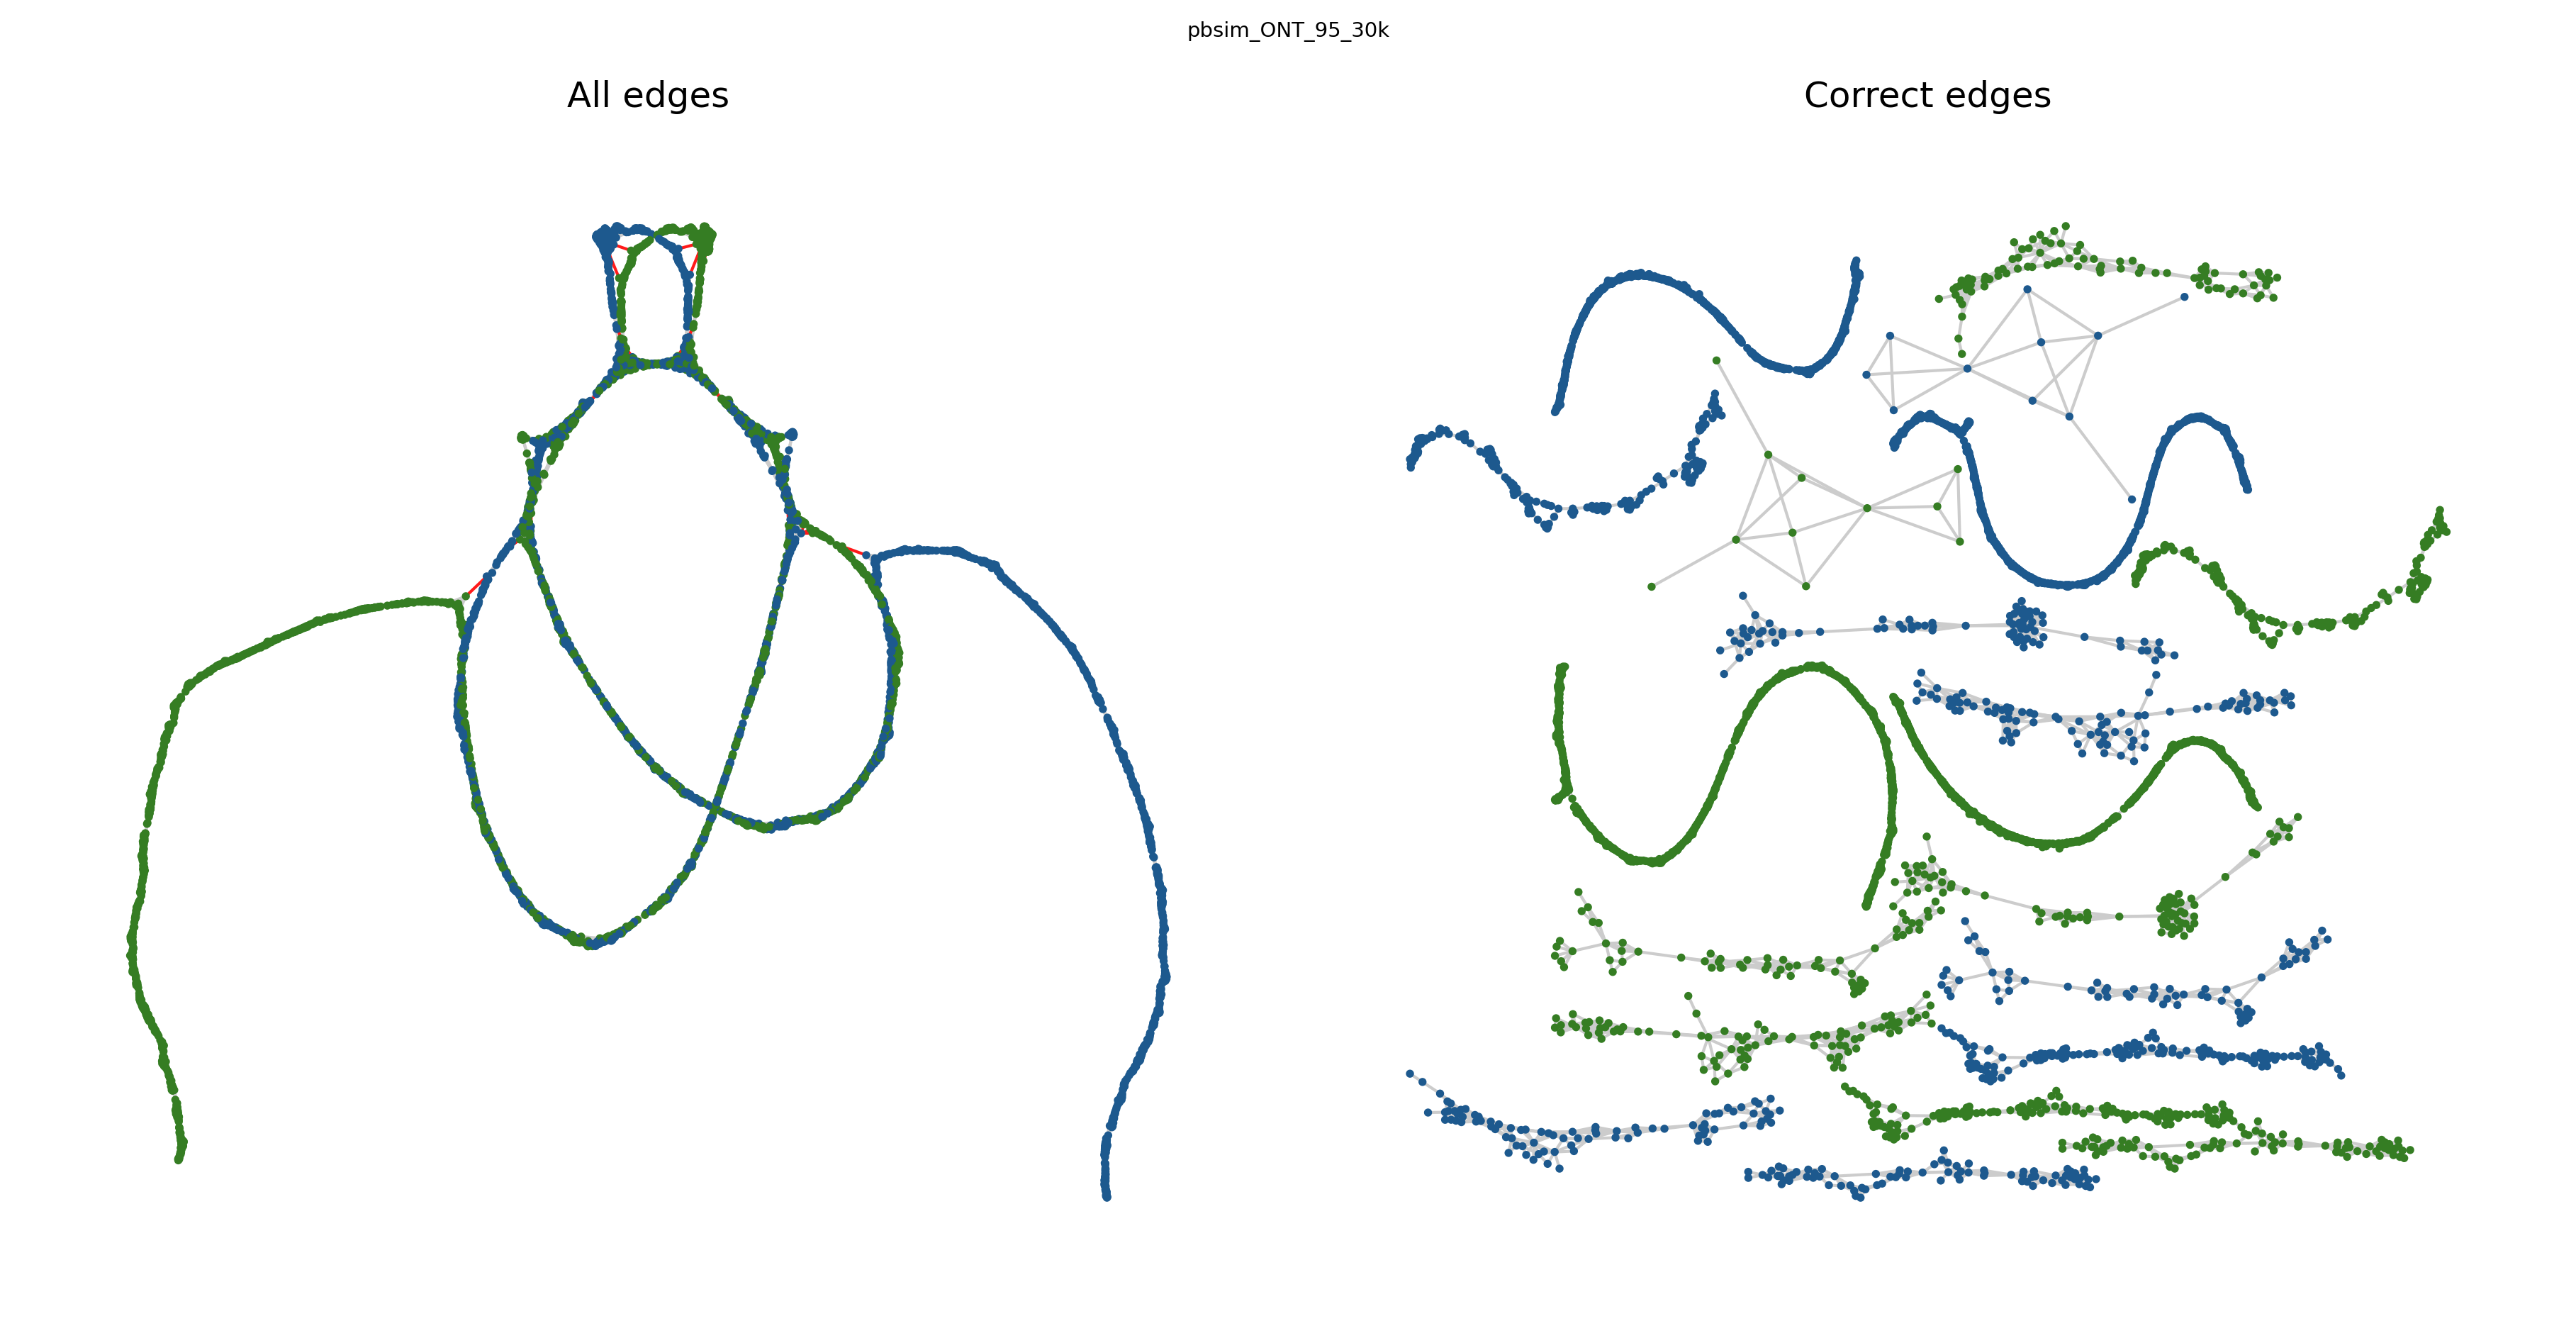

In [19]:
%%time
k6_graphs = [graphs[0][6] for i in range(len(graphs))]
plot_graphs(
    k6_graphs, reference_graph=reference_graph, metadata=meta_df, layout_method="sfdp", processes=8,title= 'pbsim_ONT_95_30k'
)

1 0 
CPU times: user 5.3 s, sys: 258 ms, total: 5.56 s
Wall time: 18min 36s


[<Figure size 3600x1800 with 2 Axes>]

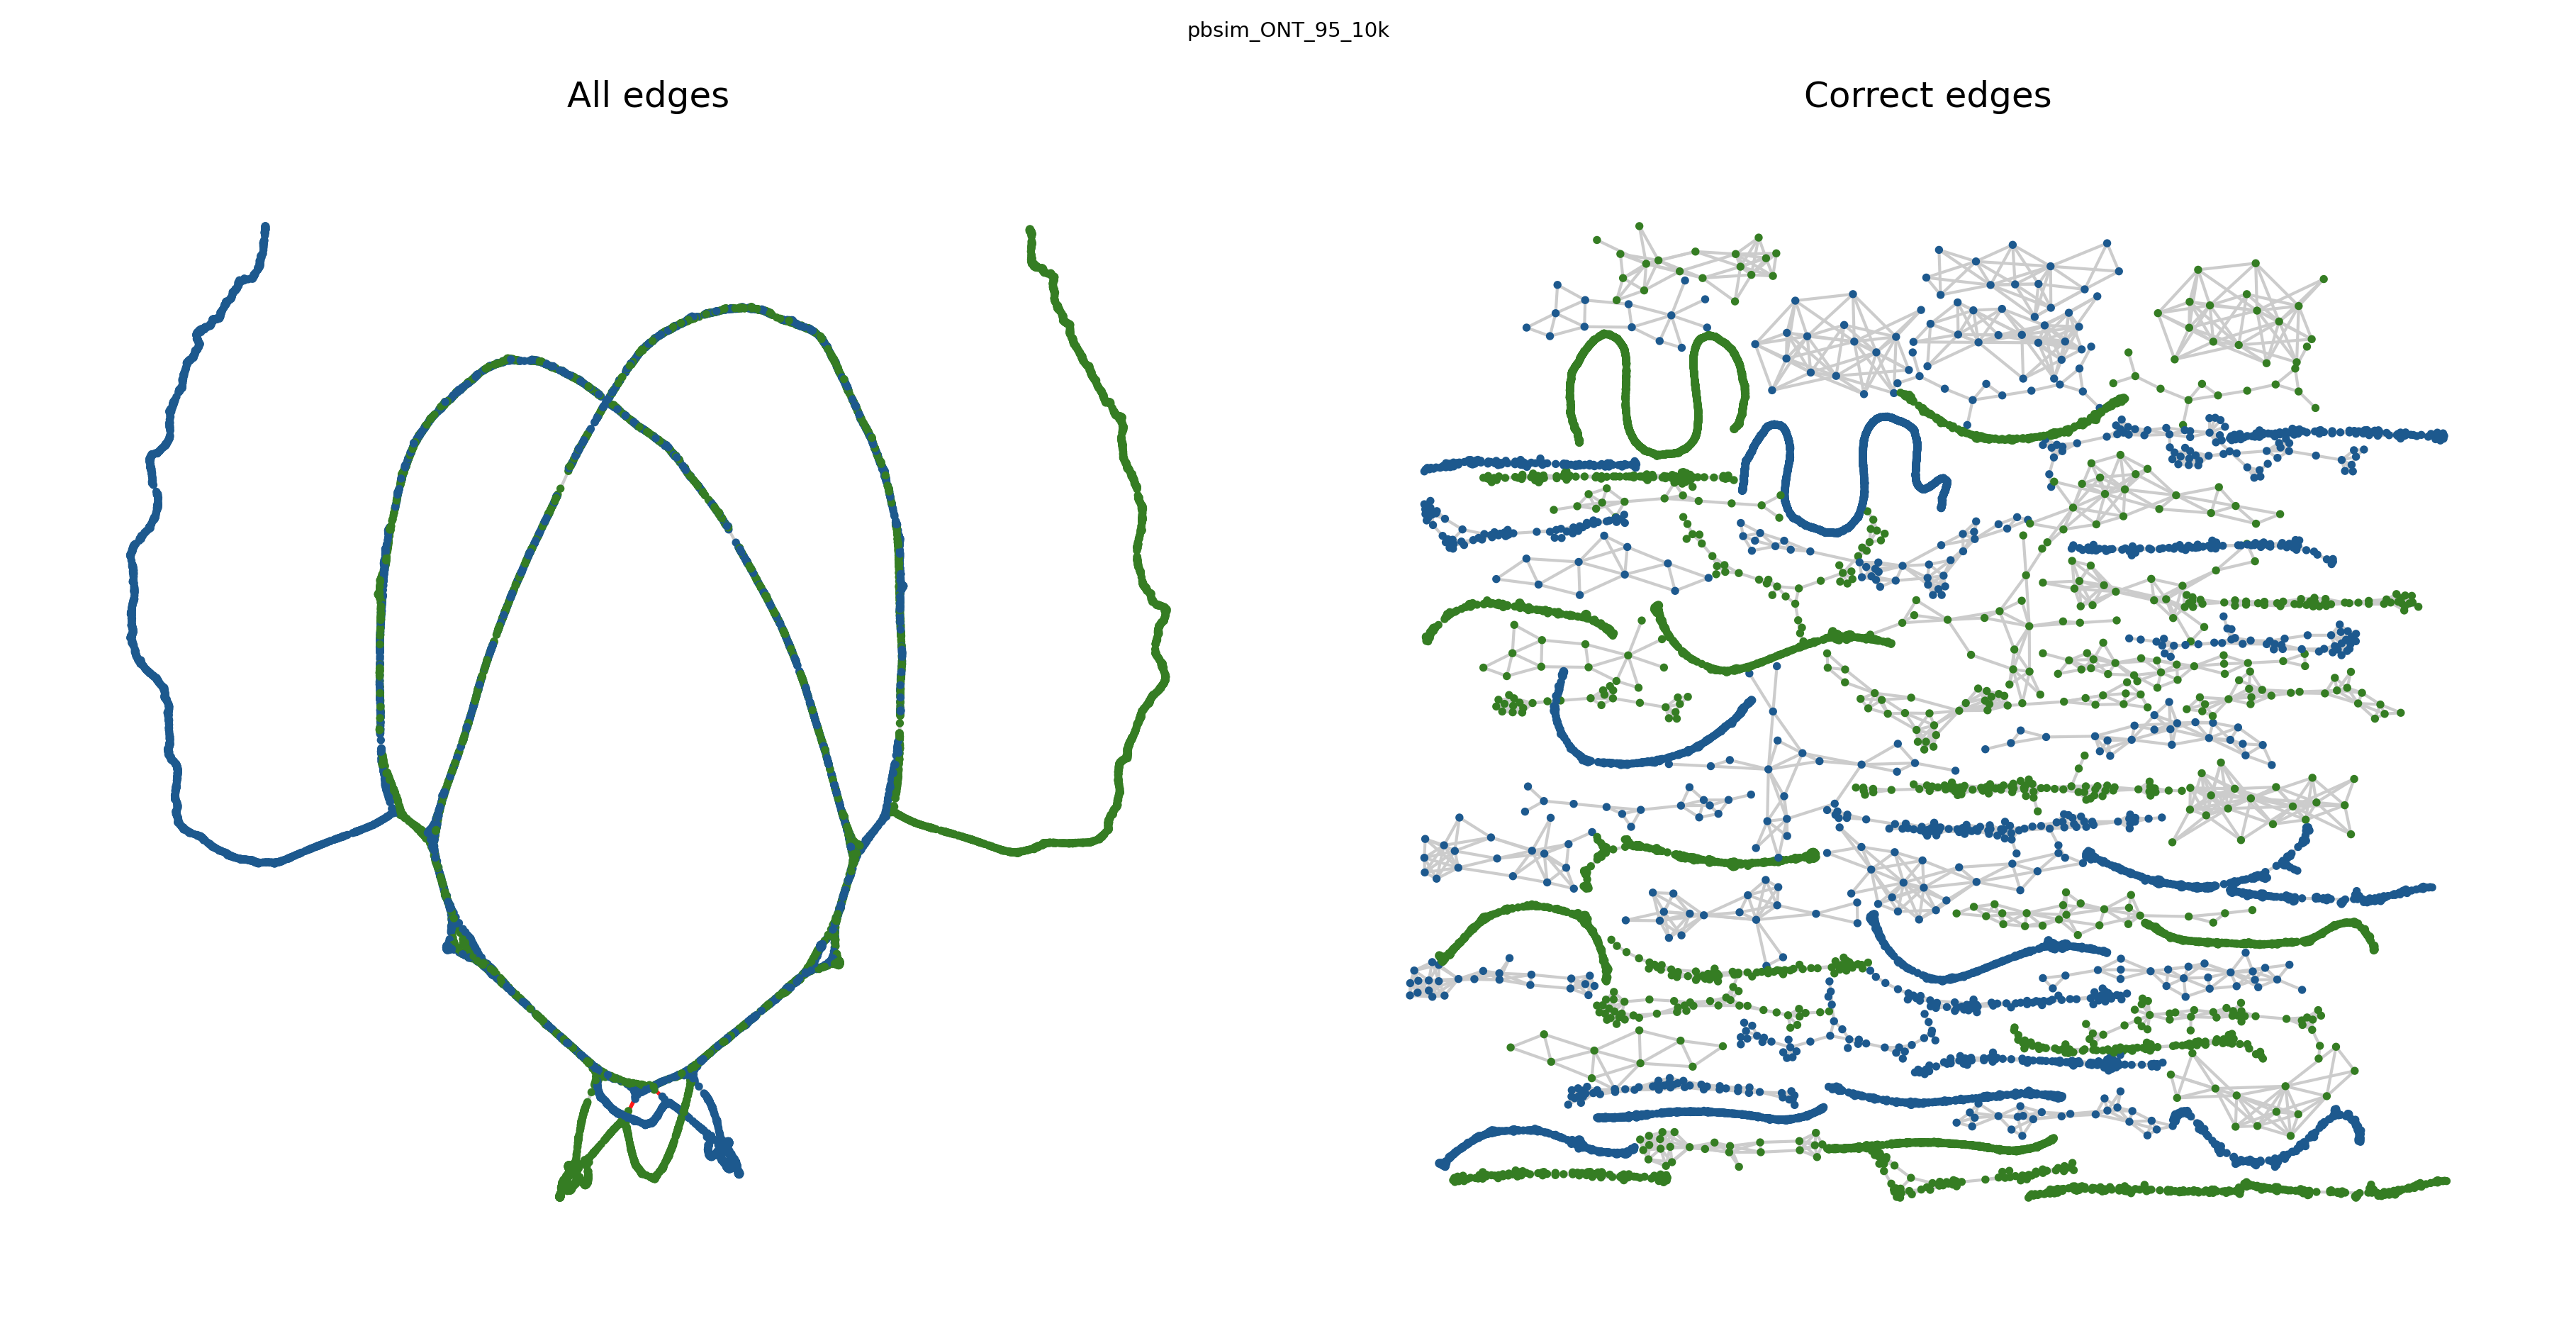

In [22]:
%%time
k6_graphs = [graphs[0][6] for i in range(len(graphs))]
plot_graphs(
    k6_graphs, reference_graph=reference_graph, metadata=meta_df, layout_method="sfdp", processes=8,title= 'pbsim_ONT_95_10k'
)

In [32]:
def get_overlap_statistics(query_graph: nx.Graph, reference_graph: nx.Graph):    
    reference_edges = set(
        tuple(sorted((node_1, node_2))) for node_1, node_2 in reference_graph.edges
    )
    nr_reference_edges = set(
        tuple(sorted((node_1, node_2)))
        for node_1, node_2, data in reference_graph.edges(data=True)
        if not data["redundant"]
    )
    query_edges = set(
        tuple(sorted((read_1, read_2))) for read_1, read_2 in query_graph.edges
    )
    true_positive_edges = query_edges & reference_edges
    nr_true_positive_edges = query_edges & nr_reference_edges

    recall = len(true_positive_edges) / len(reference_edges)
    nr_recall = len(nr_true_positive_edges) / len(nr_reference_edges)

    precision = len(true_positive_edges) / len(query_edges)
    nr_precision = len(nr_true_positive_edges) / len(query_edges)

    query_graph = query_graph.copy()
    remove_false_edges(query_graph, reference_graph)
    singleton_count = len([node for node in query_graph if len(query_graph[node]) <= 1])
    singleton_fraction = singleton_count / len(query_graph.nodes)
    component_sizes = [len(x) for x in nx.connected_components(query_graph)]
    component_sizes.sort(reverse=True)
    component_sizes = np.array(component_sizes)
    node_count = len(query_graph.nodes)
    N50 = component_sizes[component_sizes.cumsum() >= node_count * 0.5].max()
    continuity = N50/(node_count/2)
    result = dict(
        precision=precision,
        nr_precision=nr_precision,
        recall=recall,
        nr_recall=nr_recall,
        singleton_count=singleton_count,
        singleton_fraction=singleton_fraction,
        N50=N50,
        continuity=continuity,
        nr_true_positive_edges=len(nr_true_positive_edges),
        nr_reference_edges=len(nr_reference_edges),
        true_positive_edges=len(true_positive_edges),
        reference_edges=len(reference_edges),
        query_edges=len(query_edges)
    )
    return result

In [5]:
tsv_path = "/home/miaocj/docker_dir/kNN-overlap-finder/data/feature_matrix/CHM13/IGK/pbsim_ONT_95_10k/kmer_k16/metadata.tsv.gz"
json_path = "/home/miaocj/docker_dir/kNN-overlap-finder/data/feature_matrix/CHM13/IGK/pbsim_ONT_95_10k/kmer_k16/read_features.json.gz"
nbr_path = '/home/miaocj/docker_dir/kNN-overlap-finder/data/evaluation/CHM13/IGK/pbsim_ONT_95_10k/kmer_k16/Exact_Cosine_None_IDF_nbr_matrix.npz'

meta_df = pd.read_table(tsv_path).iloc[:MAX_SAMPLE_SIZE, :].reset_index()
read_indices = {read_name: read_id for read_id, read_name in meta_df['read_name'].items()}

with gzip.open(json_path, "rt") as f:
    read_features = json.load(f)
    read_features = {i: read_features[i] for i in meta_df.index}
    
data = np.load(nbr_path) 
nbr_indices = data['arr_0']

def get_read_intervals(meta_df):
    read_intervals = {
        i: [GenomicInterval(strand, start, end)]
        for i, strand, start, end in zip(
            meta_df.index,
            meta_df["reference_strand"],
            meta_df["reference_start"],
            meta_df["reference_end"],
        )
    }
    return read_intervals

read_intervals = get_read_intervals(meta_df)

reference_graph = OverlapGraph.from_intervals(read_intervals)
nr_edges = set((node_1, node_2) for node_1, node_2, data in reference_graph.edges(data=True) if not data['redundant'])
connected_component_count = len(list(nx.connected_components(reference_graph)))
len(reference_graph.nodes), len(reference_graph.edges), len(nr_edges), connected_component_count

max_n_neighbors=20
df_rows = []
read_ids = np.array(list(read_features))

k = 6
graph = OverlapGraph.from_neighbor_indices(
neighbor_indices=nbr_indices,
n_neighbors=k,
read_ids=read_ids,
require_mutual_neighbors=False,)
graph_stats = get_overlap_statistics(query_graph=graph, reference_graph=reference_graph)
stats = {"description": 'pbsim_ONT_95_10k', "n_neighbors": k, 
            **graph_stats}
df_rows.append(stats)
pd.DataFrame(df_rows)


717.6408114558473


description  n_neighbors  precision  nr_precision    recall  \
0  pbsim_ONT_95_10k            6   0.787543      0.263011  0.177838   

   nr_recall  singleton_count  singleton_fraction  N50  continuity  \
0   0.646453              216            0.019824  344    0.063142   

   nr_true_positive_edges  nr_reference_edges  true_positive_edges  \
0                   13048               20184                39070   

   reference_edges  
0           219694

In [6]:
tsv_path = "/home/miaocj/docker_dir/kNN-overlap-finder/data/feature_matrix/CHM13/IGK/pbsim_ONT_95_30k/kmer_k16/metadata.tsv.gz"
json_path = "/home/miaocj/docker_dir/kNN-overlap-finder/data/feature_matrix/CHM13/IGK/pbsim_ONT_95_30k/kmer_k16/read_features.json.gz"
nbr_path = '/home/miaocj/docker_dir/kNN-overlap-finder/data/evaluation/CHM13/IGK/pbsim_ONT_95_30k/kmer_k16/Exact_Cosine_None_IDF_nbr_matrix.npz'

meta_df = pd.read_table(tsv_path).iloc[:MAX_SAMPLE_SIZE, :].reset_index()
read_indices = {read_name: read_id for read_id, read_name in meta_df['read_name'].items()}

with gzip.open(json_path, "rt") as f:
    read_features = json.load(f)
    read_features = {i: read_features[i] for i in meta_df.index}
    
data = np.load(nbr_path) 
nbr_indices = data['arr_0']

def get_read_intervals(meta_df):
    read_intervals = {
        i: [GenomicInterval(strand, start, end)]
        for i, strand, start, end in zip(
            meta_df.index,
            meta_df["reference_strand"],
            meta_df["reference_start"],
            meta_df["reference_end"],
        )
    }
    return read_intervals

read_intervals = get_read_intervals(meta_df)

reference_graph = OverlapGraph.from_intervals(read_intervals)
nr_edges = set((node_1, node_2) for node_1, node_2, data in reference_graph.edges(data=True) if not data['redundant'])
connected_component_count = len(list(nx.connected_components(reference_graph)))
len(reference_graph.nodes), len(reference_graph.edges), len(nr_edges), connected_component_count

max_n_neighbors=20
df_rows = []
read_ids = np.array(list(read_features))

k = 6
graph = OverlapGraph.from_neighbor_indices(
neighbor_indices=nbr_indices,
n_neighbors=k,
read_ids=read_ids,
require_mutual_neighbors=False,)
graph_stats = get_overlap_statistics(query_graph=graph, reference_graph=reference_graph)
stats = {"description": 'pbsim_ONT_95_10k', "n_neighbors": k, 
            **graph_stats}
df_rows.append(stats)
pd.DataFrame(df_rows)


1525.4507235041065


description  n_neighbors  precision  nr_precision    recall  \
0  pbsim_ONT_95_10k            6   0.806566      0.235515  0.184267   

   nr_recall  singleton_count  singleton_fraction  N50  continuity  \
0   0.558657               76            0.014855  840    0.328382   

   nr_true_positive_edges  nr_reference_edges  true_positive_edges  \
0                    5524                9888                18918   

   reference_edges  
0           102666

In [10]:
tsv_path = "/home/miaocj/docker_dir/kNN-overlap-finder/data/feature_matrix/CHM13/IGK/pbsim_ONT_95_20k/kmer_k16/metadata.tsv.gz"
json_path = "/home/miaocj/docker_dir/kNN-overlap-finder/data/feature_matrix/CHM13/IGK/pbsim_ONT_95_20k/kmer_k16/read_features.json.gz"
nbr_path = '/home/miaocj/docker_dir/kNN-overlap-finder/data/evaluation/CHM13/IGK/pbsim_ONT_95_20k/kmer_k16/Exact_Cosine_None_IDF_nbr_matrix.npz'

meta_df = pd.read_table(tsv_path).iloc[:MAX_SAMPLE_SIZE, :].reset_index()
read_indices = {read_name: read_id for read_id, read_name in meta_df['read_name'].items()}

with gzip.open(json_path, "rt") as f:
    read_features = json.load(f)
    read_features = {i: read_features[i] for i in meta_df.index}
    
data = np.load(nbr_path) 
nbr_indices = data['arr_0']

def get_read_intervals(meta_df):
    read_intervals = {
        i: [GenomicInterval(strand, start, end)]
        for i, strand, start, end in zip(
            meta_df.index,
            meta_df["reference_strand"],
            meta_df["reference_start"],
            meta_df["reference_end"],
        )
    }
    return read_intervals

read_intervals = get_read_intervals(meta_df)

reference_graph = OverlapGraph.from_intervals(read_intervals)
nr_edges = set((node_1, node_2) for node_1, node_2, data in reference_graph.edges(data=True) if not data['redundant'])
connected_component_count = len(list(nx.connected_components(reference_graph)))
len(reference_graph.nodes), len(reference_graph.edges), len(nr_edges), connected_component_count

max_n_neighbors=20
df_rows = []
read_ids = np.array(list(read_features))

k = 6
graph = OverlapGraph.from_neighbor_indices(
neighbor_indices=nbr_indices,
n_neighbors=k,
read_ids=read_ids,
require_mutual_neighbors=False,)
graph_stats = get_overlap_statistics(query_graph=graph, reference_graph=reference_graph)
stats = {"description": 'pbsim_ONT_95_10k', "n_neighbors": k, 
            **graph_stats}
df_rows.append(stats)
pd.DataFrame(df_rows)


1088.36643454039


description  n_neighbors  precision  nr_precision    recall  \
0  pbsim_ONT_95_10k            6   0.801041      0.240147  0.180201   

   nr_recall  singleton_count  singleton_fraction   N50  continuity  \
0   0.569582              104            0.014481  1275    0.355054   

   nr_true_positive_edges  nr_reference_edges  true_positive_edges  \
0                    7842               13768                26158   

   reference_edges  
0           145160

1 0 


[<Figure size 3600x1800 with 2 Axes>]

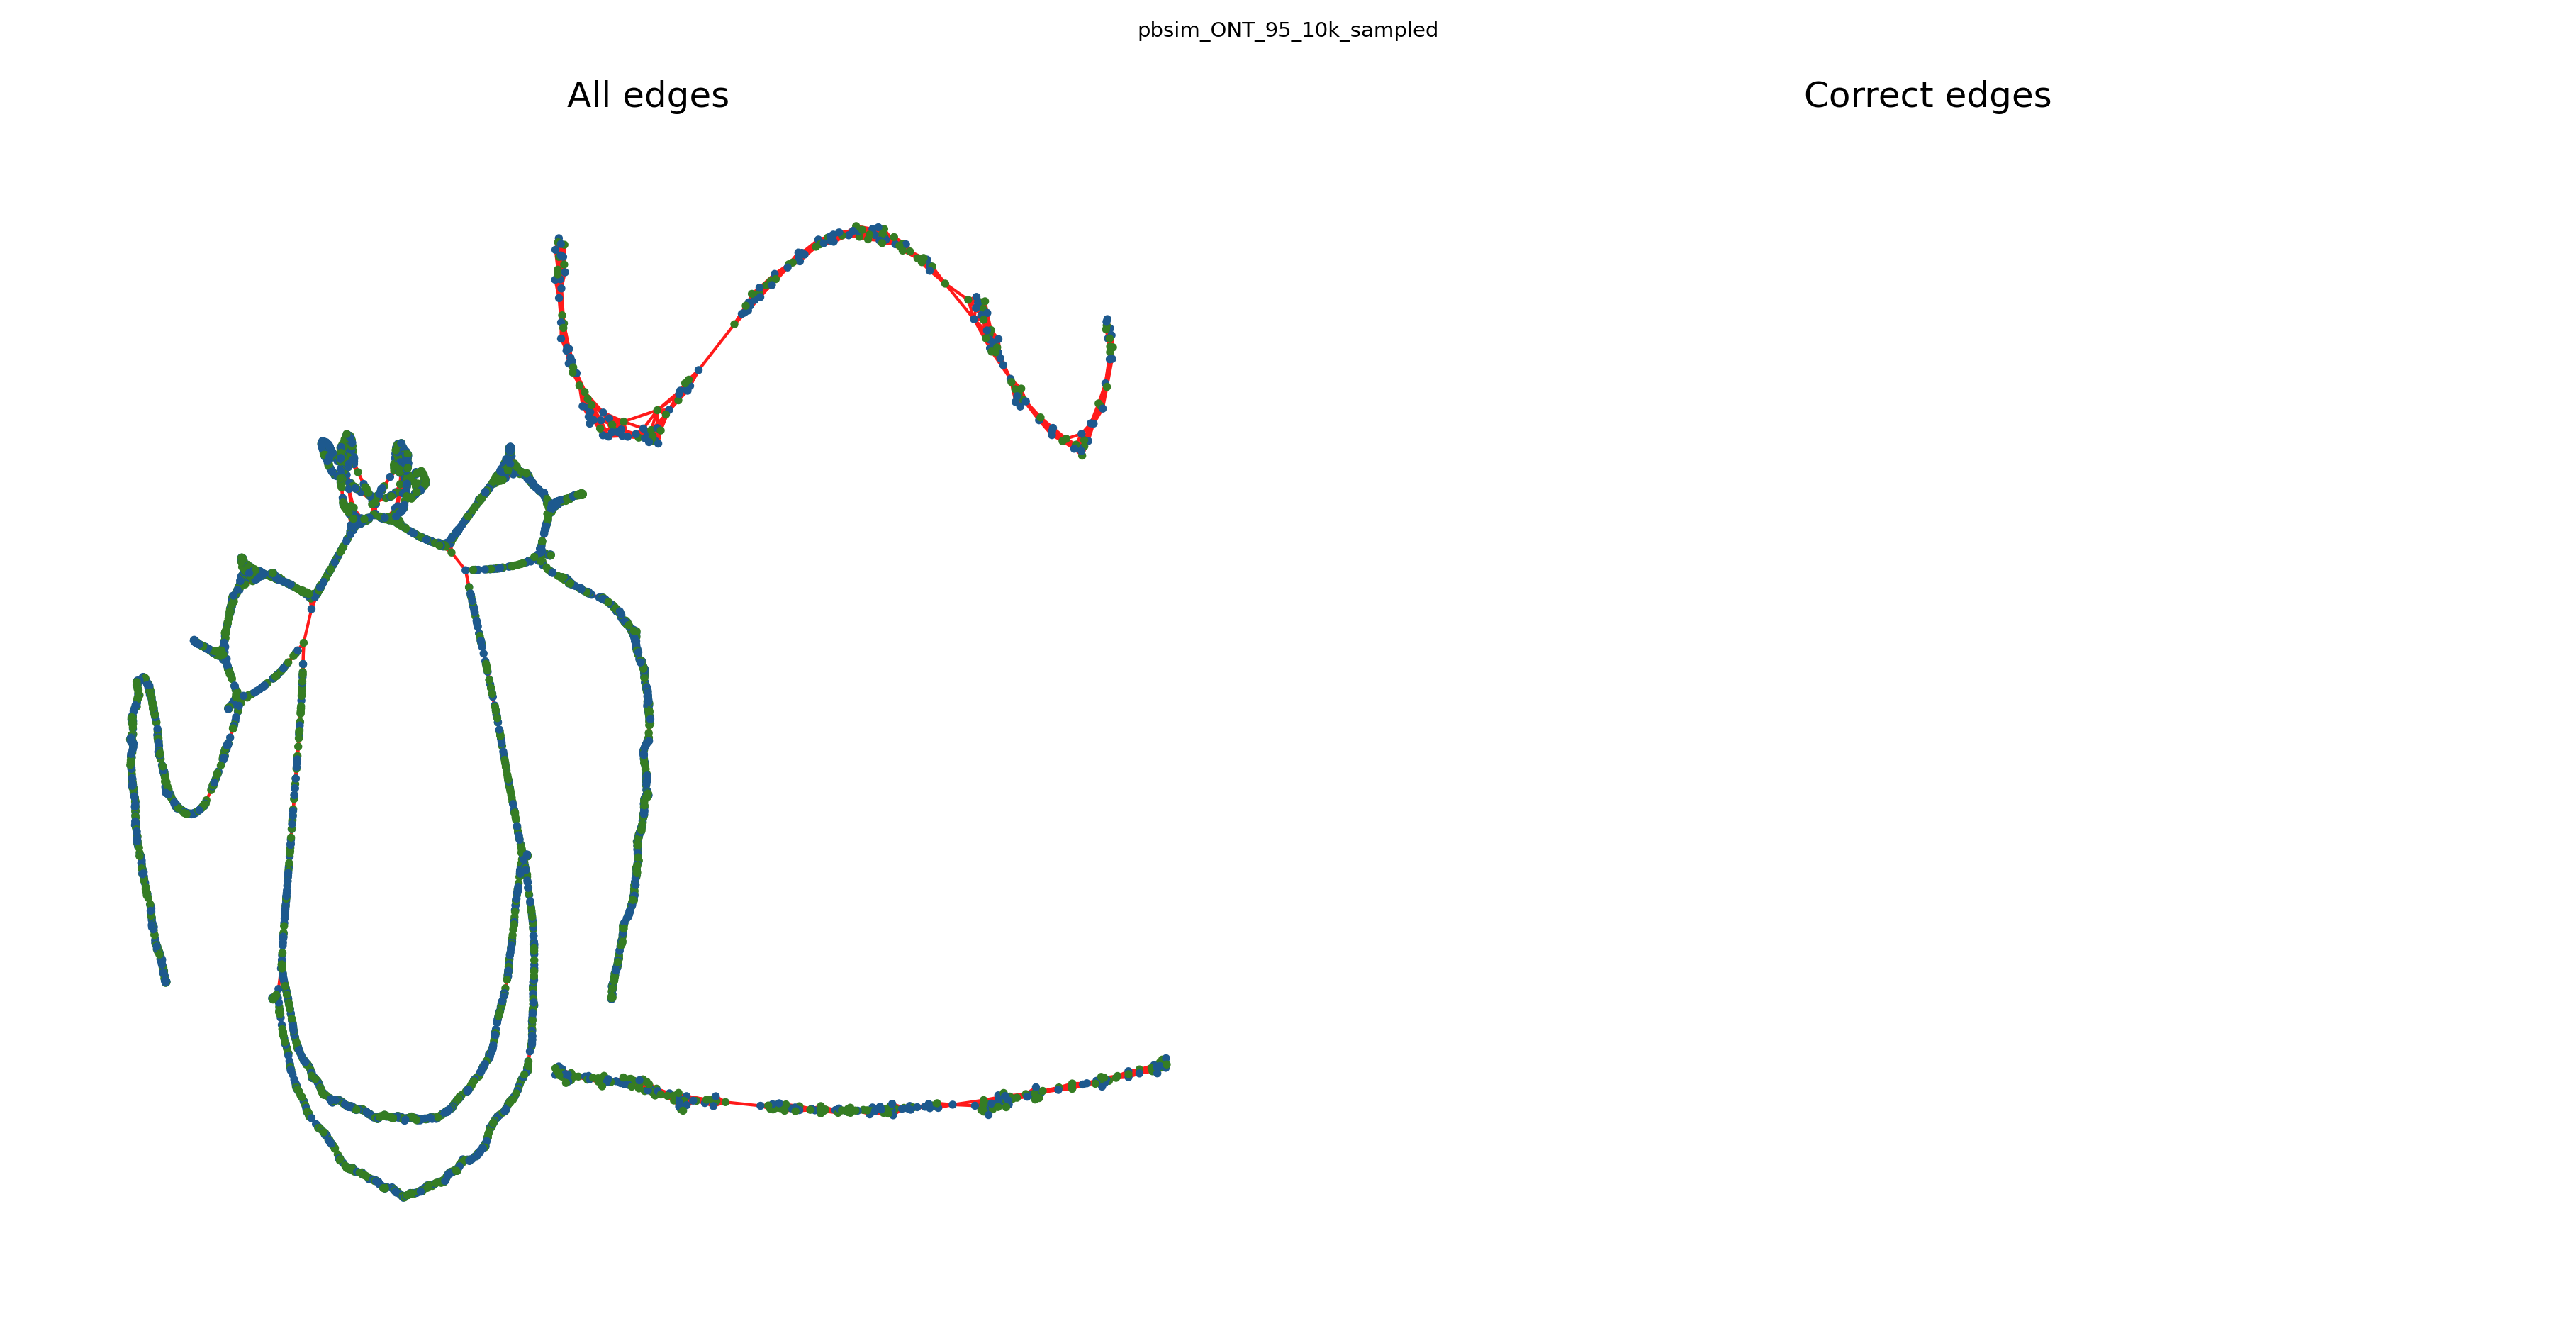

In [15]:
max_n_neighbors = 20
with gzip.open(json_path, "rt") as f:
    read_features = json.load(f)
    read_features = {i: read_features[i] for i in meta_df.index}
    
read_ids = np.array(list(read_features))
graphs = collections.defaultdict(dict)
k_values = np.arange(2, max_n_neighbors + 1)
datas = np.load('/home/miaocj/docker_dir/kNN-overlap-finder/data/evaluation/CHM13/IGK/pbsim_ONT_95_10k_sampled/kmer_k16/Exact_Cosine_None_IDF_nbr_matrix.npz',allow_pickle=True)
nbr_indices = datas['arr_0']
for k in k_values:
    graph = OverlapGraph.from_neighbor_indices(
        neighbor_indices=nbr_indices,
        n_neighbors=k,
        read_ids=read_ids,
        require_mutual_neighbors=False,
    )
    graphs[0][k] = graph

k6_graphs = [graphs[0][6] for i in range(len(graphs))]
plot_graphs(
    k6_graphs, reference_graph=reference_graph, metadata=meta_df, layout_method="sfdp", processes=8,title= 'pbsim_ONT_95_10k_sampled'
)

In [2]:
sys.path.append('/home/miaocj/docker_dir/kNN-overlap-finder/scripts')
from graph import OverlapGraph, GenomicInterval, get_overlap_statistics, remove_false_edges
from plots import plot_read_graph, mp_plot_read_graphs, get_graphviz_layout, get_umap_layout

/home/miaocj/docker_dir/kNN-overlap-finder/scripts/../lib
